# Preparation

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
from matplotlib.ticker import FormatStrFormatter
import itertools as it
from copy import deepcopy

### Exp

In [2]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

In [3]:
def load_all_configurations(exp_name:str='prova', folder_name:str= '../out/exp/'):
    experiments = {}
    for single_config in os.listdir(os.path.join(os.getcwd(),folder_name,exp_name)):
        exp_id = single_config.replace('.json', '')
        data = read_json(os.path.join(os.getcwd(),folder_name,exp_name,single_config))
        experiments[exp_id] = flatten_dict(data)
    return pd.DataFrame.from_dict(dict(sorted(experiments.items())), "index") #sorted is not actually needed

In [4]:
def load_metrics(exp_name:str='prova', folder_name:str= '../out/log/'):
    results = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        metrics_filepath = os.path.join(exp_log_folder,exp_id,'lightning_logs/version_0/metrics.csv')
        data = pd.read_csv(metrics_filepath)
        results[exp_id] = data
    return dict(sorted(results.items()))

In [5]:
def get_metrics_given_best_val(metrics_per_epoch, metrics_names, metrics_prefix = "val", metrics_dataloader_idx=1, val_prefix = "val", val_metric="NDCG@10", val_dataloader_idx=0, fix_rec_at_k=False):
    if fix_rec_at_k:
        val_metric =val_metric.replace('@','_@')
        metrics_names = [metric.replace('@','_@') for metric in metrics_names]
    val_key = f"{val_prefix}_{val_metric}"
    if val_dataloader_idx is not None:
        val_key += f"/dataloader_idx_{val_dataloader_idx}"
    metric_keys = [f"{metrics_prefix}_{metric}" for metric in metrics_names]
    if metrics_dataloader_idx is not None:
        metric_keys = [f"{metric}/dataloader_idx_{metrics_dataloader_idx}" for metric in metric_keys]
    best_metrics = {}
    for exp_id, metrics in metrics_per_epoch.items():
        best_val_row = metrics[val_key].argmax()
        best_metrics[exp_id] = {metric_name: metrics[metric_key][best_val_row] for metric_name, metric_key in zip(metrics_names,metric_keys)}
    return pd.DataFrame.from_dict(dict(sorted(best_metrics.items())), "index") #sorted is not actually needed

In [6]:
def hotfix_table(table, col, value=0.5):
    for exp_id in table.index.get_level_values(0).unique():
        exp_loc = table.index.get_level_values(0) == exp_id
        vals = table.loc[exp_loc][col][1:-1].values
        mean_vals = (table.loc[exp_loc][col][:-2].values+table.loc[exp_loc][col][2:].values)/2
        over_threshold = np.abs(vals-mean_vals)>value
        sel_app = exp_loc
        app = np.concatenate((np.array([False]),over_threshold,np.array([False])))
        sel_app[sel_app] = app
        table.loc[sel_app,col] = mean_vals[over_threshold]
    return table

In [7]:
columns_for_diffs = ['duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power',
                    'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy',
                    'energy_consumed']
columns_that_are_same = ['project_name', 'run_id', 'country_name',
    'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os',
    'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model',
    'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size',
    'tracking_mode', 'on_cloud', 'pue']
columns_that_are_different = ['timestamp']

def load_emissions(exp_name:str='prova', folder_name:str= '../out/log/'):
    emissions = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        emissions_filepath = os.path.join(exp_log_folder,exp_id,'emissions.csv')
        if not os.path.exists(emissions_filepath): continue
        data = pd.read_csv(emissions_filepath)
    
        new_data = {}
        for column in columns_for_diffs:
            #TODO: generalize to more splits / rows of emissions
            new_data[f"train_{column}"] = data.iloc[0][column]
            new_data[f"test_{column}"] = data.iloc[1][column] - data.iloc[0][column]
        for column in columns_that_are_same:
            new_data[f"{column}"] = data.iloc[0][column]
        for column in columns_that_are_different:
            new_data[f"train_{column}"] = data.iloc[0][column]
            new_data[f"test_{column}"] = data.iloc[1][column]
        emissions[exp_id] = new_data

    return pd.DataFrame.from_dict(dict(sorted(emissions.items())), "index") #sorted is not actually needed

In [8]:
modifiers = {"":1, "K":1e3, "M":1e6, "G":1e9, "T":1e12, "P":1e15}
strings_to_search = {"num_params":"params per GPU:",
                     "flops": "fwd flops per GPU:",
                     "latency": "fwd latency:",
                     "FLOPS": "fwd FLOPS per GPU = fwd flops per GPU / fwd latency:"}

def extract_flops_info(complete_string, string_to_search):
    if string_to_search in complete_string:
        value = complete_string.split(string_to_search)[1].split("\n")[0].strip()
    else: value = "nan"
    measure = ""
    if " " in value: value, measure = value.split(" ")
    scale = measure[0] if len(measure)>0 else ""
    if scale not in modifiers:
        scale = ""
        measure = " " + measure
    unit = "" if len(measure)==1 else measure[1:]
    return float(value)*modifiers[scale], unit

def load_flops(exp_name:str='prova', folder_name:str= '../out/log/', split_keys = ["train", "test"]):
    flops = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        new_data = {}
        for split_key in split_keys:
            flops_filepath = os.path.join(exp_log_folder,exp_id,f'{split_key}_flops.txt')
            if not os.path.exists(flops_filepath): continue
            #load flops_filepath txt
            with open(flops_filepath, 'r') as file:
                data = file.read()
            
            for measure_name,string_to_search in strings_to_search.items():
                value, unit = extract_flops_info(data, string_to_search)
                measure_key = f"{split_key}_{measure_name}"
                #if unit != "": measure_key += f" ({unit})"
                new_data[measure_key] = value
            
        flops[exp_id] = new_data

    return pd.DataFrame.from_dict(dict(sorted(flops.items())), "index") #sorted is not actually needed

In [9]:
## Add emissions and flops info to metrics_per_epoch
def add_info_single_df(df, exp_data, subset_col, split_name, column_labels):
    if subset_col not in df.columns:
        split_subset = np.zeros(len(df), dtype=bool)
        split_subset[-1] = True
    else:
        split_subset = ~df[subset_col].isna()
    num_split = sum(split_subset)
    for label in column_labels:
        split_label = f"{split_name}_{label}"
        df.loc[split_subset,split_label] = np.linspace(exp_data[split_label]/num_split,exp_data[split_label],num_split)
    

def add_info_to_metrics_per_epoch(metrics_per_epoch, complete_data, column_labels, split_names = ["train", "test"], repeat_for = ["val_loss/dataloader_idx_0",None]):
    for exp_id,df in metrics_per_epoch.items():
        for split_name,repeat_col in zip(split_names,repeat_for):
            add_info_single_df(df, complete_data.loc[exp_id], f"{split_name}_loss", split_name, column_labels)
            if repeat_col is not None:
                add_info_single_df(df, complete_data.loc[exp_id], repeat_col, split_name, column_labels)
        metrics_per_epoch[exp_id] = df

### Table utils

In [10]:
def subset_data(complete_data, subset_selection={}, subset_keep=[], merge_columns={}):
    subset_data = complete_data
    for label, value in subset_selection.items():
        subset_data = subset_data[subset_data[label] == value]

    for condition1, condition2 in subset_keep:
        for label, value in condition1.items():
            subset_data2 = subset_data[subset_data[label] == value]
        indices = subset_data2.index
        for label, value in condition2.items():
            subset_data2 = subset_data2[subset_data2[label] == value]
        indices2 = subset_data2.index
        #remove for subset_data idx not in indices2
        indices_to_remove = [idx for idx in indices if idx not in indices2]
        subset_data = subset_data.drop(indices_to_remove)
        
    for col_name, cols in merge_columns.items():
        subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
        subset_data = subset_data.drop(columns=cols)
    
    return subset_data

def generate_table(subset_data,
                   rows_labels, column_labels,
                   pivot_agg = lambda x: x,
                   table_name="results", save_table=False, round_at=4,
                   exp_name:str='prova', folder_name:str= '../out/results/'):

    subset_data = subset_data[rows_labels + column_labels]

    table = pd.pivot_table(subset_data, index=rows_labels, values=column_labels, dropna=False, aggfunc=pivot_agg)

    # Drop if all column_labels are nans
    drop_row = table[column_labels].isnull().all(axis=1)
    table = table[~drop_row]

    table.reset_index(inplace=True)


    table = table.round(round_at)

    if save_table:
        results_path = os.path.join(folder_name,exp_name)
        if not os.path.exists(results_path):
            os.makedirs(results_path)
        table.to_csv(os.path.join(results_path,f'{table_name}.csv'), index=False)
    return table

### Plot utils

In [11]:
def to_color_blind(color):
    if color == 'red':
        return '#e41a1c'
    elif color == 'blue':
        return '#377eb8'
    elif color == 'orange':
        return '#ff7f00'
    elif color == 'green':
        return '#4daf4a'
    elif color == 'brown':
        return '#a65628'
    elif color == 'grey':
        return '#999999'
    elif color == 'yellow':
        return '#dede00'
    elif color == 'pink':
        return '#f781bf'
    elif color == 'purple':
        return '#984ea3'
    else:
        raise NotImplementedError("color not available")

def obtain_markers(number_of_markers):
    list_of_markers = ['o', 'v', 's', 'p', 'P', '*', 'X', '+', 'D', 'x']
    return list_of_markers[:number_of_markers]

def obtain_color(number_of_colors):
    all = ['#e41a1c', '#377eb8','#ff7f00','#4daf4a','#a65628',
        '#999999','#dede00','#f781bf','#984ea3']
    return all[:number_of_colors]

In [12]:
def create_plot(plot_instructions,
                **kwargs):
    final_fig, final_ax = plt.subplots(**plot_instructions["subplots"])
    
    # If final_ax is iterable
    if hasattr(final_ax, '__iter__'):
        for i,ax in enumerate(final_ax.flatten()):
            single_plot(ax, **{k:v[i] if isinstance(v, list) or isinstance(v, tuple) else v for k,v in kwargs.items()})
    else:
        single_plot(final_ax, **kwargs)

    for plt_func, plt_kwargs in plot_instructions.items():
        if plt_func != "subplots":
            run_plot_func(plt, plt_func, plt_kwargs)

def single_plot(ax,
                data,
                label_columns: list,
                x_column: str,
                y_column: str,
                plot_type = "plot",
                plot_kwargs = {},
                ax_instructions: dict = {},
                label_convert_dict: dict = {}):
    labels = []
    for col in label_columns:
        labels.append(data[col].unique())
    labels = list(it.product(*labels))
    plot_labels = [x[0] if len(x) == 1 else x for x in labels]
    plot_labels = [label_convert_dict.get(x, x) for x in plot_labels]
    labels = [x[1] for x in sorted(zip(plot_labels,labels))]
    plot_labels = sorted(plot_labels)

    colors = obtain_color(len(labels))
    markers = obtain_markers(len(labels))
        
    for i, values in enumerate(labels):
        subset_data = data
        for col, value in zip(label_columns, values):
            subset_data = subset_data[subset_data[col] == value]
        
        x_values = subset_data[x_column]
        y_values = subset_data[y_column]
        getattr(ax,plot_type)(x_values, y_values, label=plot_labels[i], color=colors[i], marker=markers[i], **plot_kwargs)
    
    for ax_func, ax_kwargs in ax_instructions.items():
        run_plot_func(ax, ax_func, ax_kwargs.copy())

def run_plot_func(obj, func, kwargs):
    other_func_instructions = None
    if "__kwargs__" in kwargs:
        func_kwargs = kwargs.pop("__kwargs__")
        kwargs, other_func_instructions = func_kwargs, kwargs
    
    app = getattr(obj, func)(**kwargs)
    if other_func_instructions is not None:
        for func, kwargs in other_func_instructions.items():
            run_plot_func(app, func, kwargs)
    
    # for index, (model, data) in enumerate(results.items()):
    #     ablation_values = list(data.keys())
    #     y_values = list(data.values())
    #     plt.plot(ablation_values, y_values, label=model, color=colors[index], marker=markers[index])
    # 
    # plt.xticks(ablation_values, ablation_values)
    # plt.xlabel(names_to_labels[ablation_type])
    # plt.ylabel(metric)
    # plt.title(names_to_labels[dataset_name])
    # plt.legend()
    # plt.show()

In [13]:
def merge_epoch_data(metrics_per_epoch, table, table_columns = [], epoch_column_not_na = "val_loss/dataloader_idx_1"):
    subset_metrics = {}
    for exp_id in table.index:
        subset_metrics[exp_id] = metrics_per_epoch[exp_id]
    
        subset_metrics[exp_id] = subset_metrics[exp_id].loc[~subset_metrics[exp_id][epoch_column_not_na].isna()]
        
        for col in table_columns:
            subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
    
    #concat all dataframes by row
    subset_metrics = pd.concat(subset_metrics)
    
    return subset_metrics

### Important vars

In [14]:
names_to_labels = {'ml-1m' : 'MovieLens 1M', 'ml-100k' : 'MovieLens 100k', 'amazon_beauty' : 'Amazon Beauty', 'foursquare-tky' : 'Foursquare TKY', 'foursquare-nyc' : 'Foursquare NYC',
                   'emb_size' : 'Embedding Size', 'lookback' : 'Input sequence length', 'carbon_emissions' : r'CO\textsubscript{2}-eq', 'model_size' : 'Model Size',
                   'ml-20m': 'MovieLens 20M'}

In [15]:
all_datasets = sorted(['ml-1m', 'ml-100k', 'amazon_beauty', 'foursquare-tky', 'foursquare-nyc'])
all_models= sorted(['SASRec','NARM', 'GRU4Rec', 'BERT4Rec', 'CORE'])
metrics_names = ["Precision", "Recall", "NDCG", "MAP"]
metrics_ks = [5, 10, 20]
all_metrics_names = [f"{metric}@{k}" for metric in metrics_names for k in metrics_ks]

# MAIN

## Load all experiments

### Exp configs

In [16]:
exp_name = "May_8"

In [17]:
all_exps = load_all_configurations(exp_name)

In [18]:
all_exps

data_params.collator_params.lookback  \
02aTlr7kC6tzuSqW                                   200   
0kNAmyh9al6qgGzB                                   200   
0migpgTG4avYEDXM                                   200   
1uOEvgHZNXteuPNU                                   200   
2598HEdcojn1KuoB                                   200   
...                                                ...   
xJJ9K44SQ7woxFse                                   200   
xWaj0hxvcvd1doh9                                   200   
xfk16wi3gDTPByGk                                   200   
xoVHmbJ9HgHybhik                                   200   
xrwcsKySQWdvViNH                                   200   

                  data_params.collator_params.lookforward  \
02aTlr7kC6tzuSqW                                        1   
0kNAmyh9al6qgGzB                                        1   
0migpgTG4avYEDXM                                        1   
1uOEvgHZNXteuPNU                                        1   
2598HEdcojn1KuoB                                        1   
...                                                   ...   
xJJ9K44SQ7woxFse                                        1   
xWaj0hxvcvd1doh9                                        1   
xfk16wi3gDTPByGk                                        1   
xoVHmbJ9HgHybhik                                        1   
xrwcsKySQWdvViNH                                        1   

                  data_params.collator_params.num_items  \
02aTlr7kC6tzuSqW                                   1076   
0kNAmyh9al6qgGzB                                  15177   
0migpgTG4avYEDXM                                   1076   
1uOEvgHZNXteuPNU                                  15177   
2598HEdcojn1KuoB                                   1076   
...                                                 ...   
xJJ9K44SQ7woxFse                                  15177   
xWaj0hxvcvd1doh9                                  15177   
xfk16wi3gDTPByGk                                  15177   
xoVHmbJ9HgHybhik                                   1076   
xrwcsKySQWdvViNH                                   1076   

                  data_params.collator_params.num_negatives.test  \
02aTlr7kC6tzuSqW                                             100   
0kNAmyh9al6qgGzB                                             100   
0migpgTG4avYEDXM                                             100   
1uOEvgHZNXteuPNU                                             100   
2598HEdcojn1KuoB                                             100   
...                                                          ...   
xJJ9K44SQ7woxFse                                             100   
xWaj0hxvcvd1doh9                                             100   
xfk16wi3gDTPByGk                                             100   
xoVHmbJ9HgHybhik                                             100   
xrwcsKySQWdvViNH                                             100   

                  data_params.collator_params.num_negatives.train  \
02aTlr7kC6tzuSqW                                                2   
0kNAmyh9al6qgGzB                                               50   
0migpgTG4avYEDXM                                               20   
1uOEvgHZNXteuPNU                                                3   
2598HEdcojn1KuoB                                               10   
...                                                           ...   
xJJ9K44SQ7woxFse                                                1   
xWaj0hxvcvd1doh9                                                5   
xfk16wi3gDTPByGk                                                1   
xoVHmbJ9HgHybhik                                                1   
xrwcsKySQWdvViNH                                                1   

                  data_params.collator_params.num_negatives.val  \
02aTlr7kC6tzuSqW                                              1   
0kNAmyh9al6qgGzB                                              1   
0migpgTG4avYEDXM                

### Load exp metrics

In [19]:
metrics_per_epoch = load_metrics(exp_name)
metrics_per_epoch

{'02aTlr7kC6tzuSqW':       epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  test_MAP_@10  \
 0         0     9          NaN          NaN         NaN           NaN   
 1         0     9          NaN          NaN         NaN           NaN   
 2         1    19          NaN          NaN         NaN           NaN   
 3         1    19          NaN          NaN         NaN           NaN   
 4         2    29          NaN          NaN         NaN           NaN   
 ...     ...   ...          ...          ...         ...           ...   
 1196    598  5989          NaN          NaN         NaN           NaN   
 1197    598  5989          NaN          NaN         NaN           NaN   
 1198    599  5999          NaN          NaN         NaN           NaN   
 1199    599  5999          NaN          NaN         NaN           NaN   
 1200    600  6000     0.172072     0.090354     0.31494      0.197491   
 
       test_MAP_@20  test_MAP_@5  test_MRR_@10  test_MRR_@20  ...  \
 0              NaN  

In [20]:
best_metrics = get_metrics_given_best_val(metrics_per_epoch, all_metrics_names, fix_rec_at_k=True)
best_metrics

Precision_@5  Precision_@10  Precision_@20  Recall_@5  \
02aTlr7kC6tzuSqW      0.132182       0.068995       0.035911   0.660911   
0kNAmyh9al6qgGzB      0.151417       0.076014       0.038007   0.757087   
0migpgTG4avYEDXM      0.135165       0.069545       0.036342   0.675824   
1uOEvgHZNXteuPNU      0.143829       0.080026       0.043502   0.719145   
2598HEdcojn1KuoB      0.134066       0.068995       0.036342   0.670330   
...                        ...            ...            ...        ...   
xJJ9K44SQ7woxFse      0.152987       0.083384       0.044374   0.764937   
xWaj0hxvcvd1doh9      0.154993       0.084300       0.044592   0.774967   
xfk16wi3gDTPByGk      0.108940       0.065198       0.037462   0.544701   
xoVHmbJ9HgHybhik      0.116013       0.061931       0.033752   0.580063   
xrwcsKySQWdvViNH      0.113815       0.061931       0.033203   0.569074   

                  Recall_@10  Recall_@20   NDCG_@5  NDCG_@10  NDCG_@20  \
02aTlr7kC6tzuSqW    0.689953    0.718210  0.559690  0.569189  0.576260   
0kNAmyh9al6qgGzB    0.760140    0.760140  0.718497  0.719556  0.719556   
0migpgTG4avYEDXM    0.695447    0.726845  0.574750  0.581057  0.588819   
1uOEvgHZNXteuPNU    0.800262    0.870039  0.594005  0.620330  0.638046   
2598HEdcojn1KuoB    0.689953    0.726845  0.560624  0.567162  0.576517   
...                      ...         ...       ...       ...       ...   
xJJ9K44SQ7woxFse    0.833842    0.887484  0.679840  0.702181  0.715791   
xWaj0hxvcvd1doh9    0.843000    0.891845  0.700967  0.723031  0.735348   
xfk16wi3gDTPByGk    0.651984    0.749237  0.444655  0.479190  0.503806   
xoVHmbJ9HgHybhik    0.619309    0.675039  0.481082  0.493691  0.507681   
xrwcsKySQWdvViNH    0.619309    0.664050  0.442247  0.458815  0.469975   

                    MAP_@5   MAP_@10   MAP_@20  
02aTlr7kC6tzuSqW  0.242750  0.165270  0.106183  
0kNAmyh9al6qgGzB  0.323502  0.210808  0.130822  
0migpgTG4avYEDXM  0.249822  0.169280  0.108367  
1uOEvgHZNXteuPNU  0.252556  0.175951  0.116066  
2598HEdcojn1KuoB  0.241570  0.164981  0.106264  
...                    ...       ...       ...  
xJJ9K44SQ7woxFse  0.298318  0.201273  0.129540  
xWaj0hxvcvd1doh9  0.309615  0.207536  0.132843  
xfk16wi3gDTPByGk  0.187779  0.133108  0.090170  
xoVHmbJ9HgHybhik  0.206575  0.142202  0.092781  
xrwcsKySQWdvViNH  0.181999  0.129945  0.086413  

[132 rows x 12 columns]

In [21]:
emissions = load_emissions(exp_name)
emissions

train_duration  test_duration  train_emissions  \
02aTlr7kC6tzuSqW      433.094758       0.435922         0.010984   
0kNAmyh9al6qgGzB     2672.635137       1.442340         0.080940   
0migpgTG4avYEDXM      437.518964       0.457911         0.014315   
1uOEvgHZNXteuPNU     2683.543799       1.457351         0.069908   
2598HEdcojn1KuoB      438.187691       0.462429         0.013810   
...                          ...            ...              ...   
xJJ9K44SQ7woxFse     2821.985904       1.476603         0.116780   
xWaj0hxvcvd1doh9     2780.573722       1.498861         0.091738   
xfk16wi3gDTPByGk     2411.888627       1.503932         0.093441   
xoVHmbJ9HgHybhik      447.426190       0.444714         0.016956   
xrwcsKySQWdvViNH      449.795229       0.436129         0.017145   

                  test_emissions  train_emissions_rate  test_emissions_rate  \
02aTlr7kC6tzuSqW        0.000012              0.000025         2.774633e-09   
0kNAmyh9al6qgGzB        0.000039              0.000030        -1.895893e-09   
0migpgTG4avYEDXM        0.000015              0.000033         4.343133e-10   
1uOEvgHZNXteuPNU        0.000036              0.000026        -8.012822e-10   
2598HEdcojn1KuoB        0.000014              0.000032        -4.365834e-10   
...                          ...                   ...                  ...   
xJJ9K44SQ7woxFse        0.000063              0.000041         5.629620e-10   
xWaj0hxvcvd1doh9        0.000053              0.000033         1.145897e-09   
xfk16wi3gDTPByGk        0.000042              0.000039        -6.711533e-09   
xoVHmbJ9HgHybhik        0.000015              0.000038        -4.102690e-09   
xrwcsKySQWdvViNH        0.000015              0.000038        -2.640219e-09   

                  train_cpu_power  test_cpu_power  train_gpu_power  \
02aTlr7kC6tzuSqW             95.0             0.0       201.665390   
0kNAmyh9al6qgGzB             95.0             0.0       179.670204   
0migpgTG4avYEDXM             95.0             0.0       261.782690   
1uOEvgHZNXteuPNU             95.0             0.0       172.746627   
2598HEdcojn1KuoB             95.0             0.0       243.589913   
...                           ...             ...              ...   
xJJ9K44SQ7woxFse             95.0             0.0       314.019357   
xWaj0hxvcvd1doh9             95.0             0.0       269.309621   
xfk16wi3gDTPByGk             95.0             0.0       219.494425   
xoVHmbJ9HgHybhik             95.0             0.0       305.696571   
xrwcsKySQWdvViNH             95.0             0.0       306.983523   

                  test_gpu_power  ...  gpu_count             gpu_model  \
02aTlr7kC6tzuSqW        1.114907  ...          3  3 x NVIDIA RTX A4000   
0kNAmyh9al6qgGzB        7.504923  ...          3  3 x NVIDIA RTX A4000   
0migpgTG4avYEDXM       -6.324410  ...          3  3 x NVIDIA RTX A4000   
1uOEvgHZNXteuPNU       -8.683044  ...          3  3 x NVIDIA RTX A4000   
2598HEdcojn1KuoB       -9.721915  ...          3  3 x NVIDIA RTX A4000   
...                          ...  ...        ...                   ...   
xJJ9K44SQ7woxFse       40.153194  ...          3  3 x NVIDIA RTX A4000   
xWaj0hxvcvd1doh9        6.709714  ...          3  3 x NVIDIA RTX A4000   
xfk16wi3gDTPByGk      -19.242451  ...          3  3 x NVIDIA RTX A4000   
xoVHmbJ9HgHybhik      -43.424508  ...          3  3 x NVIDIA RTX A4000   
xrwcsKySQWdvViNH      -27.025596  ...          3  3 x NVIDIA RTX A4000   

                  longitude  latitude  ram_total_size  tracking_mode  \
02aTlr7kC6tzuSqW    14.2385    40.867       62.646286        process   
0kNAmyh9al6qgGzB    14.2385    40.867       62.646286        process   
0migpgTG4avYEDXM    14.2385    40.867       62.646286        process   
1uOEvgHZNXteuPNU    14.2385    40.867       62.646286        process   
2598HEdcojn1KuoB    14.2385    40.867       62.646286        process   
...                     ...       ...             ...            ...   
xJJ9K44SQ7woxFse  

In [22]:
all_flops = load_flops(exp_name)
all_flops

train_num_params   train_flops  train_latency   train_FLOPS  \
02aTlr7kC6tzuSqW          282360.0  1.945400e+14          50.29  3.870000e+12   
0kNAmyh9al6qgGzB         1030000.0  1.138910e+15         197.22  5.770000e+12   
0migpgTG4avYEDXM          282360.0  1.945400e+14          50.14  3.880000e+12   
1uOEvgHZNXteuPNU         3000000.0  3.330330e+15         605.43  5.500000e+12   
2598HEdcojn1KuoB          282360.0  1.945400e+14          50.15  3.880000e+12   
...                            ...           ...            ...           ...   
xJJ9K44SQ7woxFse         3000000.0  3.330330e+15         619.57  5.380000e+12   
xWaj0hxvcvd1doh9         3000000.0  3.330330e+15         609.82  5.460000e+12   
xfk16wi3gDTPByGk         1030000.0  1.307990e+15         152.72  8.560000e+12   
xoVHmbJ9HgHybhik          282360.0  1.945400e+14          50.81  3.830000e+12   
xrwcsKySQWdvViNH          282360.0  1.945400e+14          51.08  3.810000e+12   

                  test_num_params    test_flops  test_latency    test_FLOPS  
02aTlr7kC6tzuSqW         282360.0  1.080500e+11         30.41  3.550000e+12  
0kNAmyh9al6qgGzB        1030000.0  6.561300e+11         64.09  1.024000e+13  
0migpgTG4avYEDXM         282360.0  1.080500e+11         30.51  3.540000e+12  
1uOEvgHZNXteuPNU        3000000.0  1.850000e+12        336.51  5.500000e+12  
2598HEdcojn1KuoB         282360.0  1.080500e+11         29.21  3.700000e+12  
...                           ...           ...           ...           ...  
xJJ9K44SQ7woxFse        3000000.0  1.850000e+12        340.40  5.430000e+12  
xWaj0hxvcvd1doh9        3000000.0  1.850000e+12        337.92  5.470000e+12  
xfk16wi3gDTPByGk        1030000.0  7.500500e+11         65.78  1.140000e+13  
xoVHmbJ9HgHybhik         282360.0  1.080500e+11         30.32  3.560000e+12  
xrwcsKySQWdvViNH         282360.0  1.080500e+11         29.69  3.640000e+12  

[132 rows x 8 columns]

In [23]:
complete_data = all_exps.join([best_metrics, emissions, all_flops], how='inner')
#join[all_exps, best_metrics, emissions, all_flops], axis=1)
metrics_per_epoch = {exp_id: metrics_per_epoch[exp_id] for exp_id in complete_data.index}
complete_data

data_params.collator_params.lookback  \
02aTlr7kC6tzuSqW                                   200   
0kNAmyh9al6qgGzB                                   200   
0migpgTG4avYEDXM                                   200   
1uOEvgHZNXteuPNU                                   200   
2598HEdcojn1KuoB                                   200   
...                                                ...   
xJJ9K44SQ7woxFse                                   200   
xWaj0hxvcvd1doh9                                   200   
xfk16wi3gDTPByGk                                   200   
xoVHmbJ9HgHybhik                                   200   
xrwcsKySQWdvViNH                                   200   

                  data_params.collator_params.lookforward  \
02aTlr7kC6tzuSqW                                        1   
0kNAmyh9al6qgGzB                                        1   
0migpgTG4avYEDXM                                        1   
1uOEvgHZNXteuPNU                                        1   
2598HEdcojn1KuoB                                        1   
...                                                   ...   
xJJ9K44SQ7woxFse                                        1   
xWaj0hxvcvd1doh9                                        1   
xfk16wi3gDTPByGk                                        1   
xoVHmbJ9HgHybhik                                        1   
xrwcsKySQWdvViNH                                        1   

                  data_params.collator_params.num_items  \
02aTlr7kC6tzuSqW                                   1076   
0kNAmyh9al6qgGzB                                  15177   
0migpgTG4avYEDXM                                   1076   
1uOEvgHZNXteuPNU                                  15177   
2598HEdcojn1KuoB                                   1076   
...                                                 ...   
xJJ9K44SQ7woxFse                                  15177   
xWaj0hxvcvd1doh9                                  15177   
xfk16wi3gDTPByGk                                  15177   
xoVHmbJ9HgHybhik                                   1076   
xrwcsKySQWdvViNH                                   1076   

                  data_params.collator_params.num_negatives.test  \
02aTlr7kC6tzuSqW                                             100   
0kNAmyh9al6qgGzB                                             100   
0migpgTG4avYEDXM                                             100   
1uOEvgHZNXteuPNU                                             100   
2598HEdcojn1KuoB                                             100   
...                                                          ...   
xJJ9K44SQ7woxFse                                             100   
xWaj0hxvcvd1doh9                                             100   
xfk16wi3gDTPByGk                                             100   
xoVHmbJ9HgHybhik                                             100   
xrwcsKySQWdvViNH                                             100   

                  data_params.collator_params.num_negatives.train  \
02aTlr7kC6tzuSqW                                                2   
0kNAmyh9al6qgGzB                                               50   
0migpgTG4avYEDXM                                               20   
1uOEvgHZNXteuPNU                                                3   
2598HEdcojn1KuoB                                               10   
...                                                           ...   
xJJ9K44SQ7woxFse                                                1   
xWaj0hxvcvd1doh9                                                5   
xfk16wi3gDTPByGk                                                1   
xoVHmbJ9HgHybhik                                                1   
xrwcsKySQWdvViNH                                                1   

                  data_params.collator_params.num_negatives.val  \
02aTlr7kC6tzuSqW                                              1   
0kNAmyh9al6qgGzB                                              1   
0migpgTG4avYEDXM                

In [24]:
column_labels = ['duration', 'emissions', 'emissions_rate', 'cpu_power','gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'flops', 'latency', 'FLOPS']
add_info_to_metrics_per_epoch(metrics_per_epoch, complete_data, column_labels)
metrics_per_epoch

{'02aTlr7kC6tzuSqW':       epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  test_MAP_@10  \
 0         0     9          NaN          NaN         NaN           NaN   
 1         0     9          NaN          NaN         NaN           NaN   
 2         1    19          NaN          NaN         NaN           NaN   
 3         1    19          NaN          NaN         NaN           NaN   
 4         2    29          NaN          NaN         NaN           NaN   
 ...     ...   ...          ...          ...         ...           ...   
 1196    598  5989          NaN          NaN         NaN           NaN   
 1197    598  5989          NaN          NaN         NaN           NaN   
 1198    599  5999          NaN          NaN         NaN           NaN   
 1199    599  5999          NaN          NaN         NaN           NaN   
 1200    600  6000     0.172072     0.090354     0.31494      0.197491   
 
       test_MAP_@20  test_MAP_@5  test_MRR_@10  test_MRR_@20  ...  \
 0              NaN  

## Table generation

In [25]:
#for col in sorted(complete_data.columns): print(col)

In [26]:
rows_labels = ["data_params.name","model.rec_model.name", "data_params.collator_params.simultaneous_lookforward", "data_params.collator_params.num_negatives.train"]
metrics_names = ["Precision", "Recall", "NDCG", "MAP"]
metrics_ks = [5, 10, 20]
column_labels = sorted([f"{metric}_@{k}" for metric in metrics_names for k in metrics_ks])
subset_selection = {} #"data_params.collator_params.lookback":200, "model.rec_model.emb_size":64}
subset_keep = [] #[{"model.rec_model.ss_name":"LSSL"},{"model.rec_model.ss_config.channels":1}],
#                [{"model.rec_model.ss_name":"Mamba"},{"model.rec_model.ss_config.d_state":16}]]
merge_columns = {} #"model_name":["model.rec_model.name","model.rec_model.ss_name","model.rec_model.ss_config.mode"]}

In [27]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True, pivot_agg=max)
table

/tmp/ipykernel_612398/2013779122.py:31: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  table = pd.pivot_table(subset_data, index=rows_labels, values=column_labels, dropna=False, aggfunc=pivot_agg)


data_params.name model.rec_model.name  \
0      amazon_beauty              GRU4Rec   
1      amazon_beauty              GRU4Rec   
2      amazon_beauty              GRU4Rec   
3      amazon_beauty              GRU4Rec   
4      amazon_beauty              GRU4Rec   
..               ...                  ...   
127            ml-1m               SASRec   
128            ml-1m               SASRec   
129            ml-1m               SASRec   
130            ml-1m               SASRec   
131            ml-1m               SASRec   

     data_params.collator_params.simultaneous_lookforward  \
0                                                    1      
1                                                    1      
2                                                    1      
3                                                    1      
4                                                    1      
..                                                 ...      
127                                                 20      
128                                                 50      
129                                                 50      
130                                                100      
131                                                100      

     data_params.collator_params.num_negatives.train  MAP_@10  MAP_@20  \
0                                                  1   0.1865   0.1165   
1                                                  2   0.1653   0.1062   
2                                                  3   0.1530   0.1000   
3                                                  5   0.1730   0.1104   
4                                                 10   0.1650   0.1063   
..                                               ...      ...      ...   
127                                               20   0.0764   0.0588   
128                                                1   0.0584   0.0468   
129                                               50   0.0591   0.0470   
130                                                1   0.0562   0.0454   
131                                              100   0.0573   0.0455   

     MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
0    0.2855    0.6387    0.6457   0.6340         0.0683         0.0356   
1    0.2427    0.5692    0.5763   0.5597         0.0690         0.0359   
2    0.2184    0.5302    0.5409   0.5194         0.0686         0.0365   
3    0.2578    0.5926    0.6030   0.5854         0.0691         0.0366   
4    0.2416    0.5672    0.5765   0.5606         0.0690         0.0363   
..      ...       ...       ...      ...            ...            ...   
127  0.0935    0.2980    0.3360   0.2459         0.0524         0.0337   
128  0.0693    0.2318    0.2791   0.1876         0.0426         0.0307   
129  0.0705    0.2335    0.2770   0.1889         0.0426         0.0299   
130  0.0664    0.2245    0.2718   0.1795         0.0417         0.0302   
131  0.0678    0.2288    0.2633   0.1820         0.0422         0.0278   

     Precision_@5  Recall_@10  Recall_@20  Recall_@5  
0          0.1338      0.6829      0.7111     0.6688  
1          0.1322      0.6900      0.7182     0.6609  
2          0.1308      0.6860      0.7300     0.6538  
3          0.1338      0.6907      0.7316     0.6688  
4          0.1341      0.6900      0.7268     0.6703  
..            ...         ...         ...        ...  
127        0.0726      0.5242      0.6730     0.3631  
128        0.0577      0.4263      0.6147     0.2887  
129        0.0575      0.4262      0.5980     0.2877  
130        0.0554      0.4169      0.6048     0.2768  
131        0.0553      0.4219      0.5568     0.2767  

[132 rows x 16 columns]

In [28]:
# # To check which rows are duplicated
# df = complete_data.loc[(complete_data["model.rec_model.name"]=="SASRec") & (complete_data["data_params.name"]=="ml-1m")]
# #Find columns in df with different values
# columns_with_different_values = []
# for column in df.columns:
#     if len(df[column].apply(lambda x: str(x)).unique()) > 1:
#         columns_with_different_values.append(column)
# print(columns_with_different_values)
# complete_data.loc[(complete_data["model.rec_model.name"]=="SASRec") & (complete_data["data_params.name"]=="ml-1m")][columns_with_different_values]

## Plot

In [29]:
main_rows_labels = ["data_params.name","model.rec_model.name"]
metrics_names = ["Precision", "Recall", "NDCG", "MAP"]
metrics_ks = [5, 10, 20]
column_labels = sorted([f"{metric}_@{k}" for metric in metrics_names for k in metrics_ks])
column_labels += ["train_flops", "test_flops", "train_FLOPS", "test_FLOPS"]
subset_keep = []
merge_columns = {}

### Num positives

In [30]:
main_x_column = "data_params.collator_params.simultaneous_lookforward"
main_x_label = "Number of positive items"
super_plot_name = "positives_NDCG@10"
super_title = "Performance with varying number of positive items"

In [31]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {"data_params.collator_params.num_negatives.train":1}

#### Amazon-beauty

In [32]:
subset_selection["data_params.name"] = "amazon_beauty"
subset_selection.pop("model.rec_model.name",None)

In [33]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0     amazon_beauty              GRU4Rec   
1     amazon_beauty              GRU4Rec   
2     amazon_beauty              GRU4Rec   
3     amazon_beauty              GRU4Rec   
4     amazon_beauty              GRU4Rec   
5     amazon_beauty              GRU4Rec   
6     amazon_beauty              GRU4Rec   
7     amazon_beauty              GRU4Rec   
8     amazon_beauty               SASRec   
9     amazon_beauty               SASRec   
10    amazon_beauty               SASRec   
11    amazon_beauty               SASRec   
12    amazon_beauty               SASRec   
13    amazon_beauty               SASRec   
14    amazon_beauty               SASRec   
15    amazon_beauty               SASRec   

    data_params.collator_params.simultaneous_lookforward  MAP_@10  MAP_@20  \
0                                                   1      0.1865   0.1165   
1                                                   2      0.1793   0.1130   
2                                                   3      0.1422   0.0928   
3                                                   5      0.1410   0.0921   
4                                                  10      0.1299   0.0864   
5                                                  20      0.1255   0.0842   
6                                                  50      0.1255   0.0842   
7                                                 100      0.1255   0.0842   
8                                                   1      0.1246   0.0858   
9                                                   2      0.0952   0.0657   
10                                                  3      0.0972   0.0664   
11                                                  5      0.1068   0.0759   
12                                                 10      0.1266   0.0861   
13                                                 20      0.1265   0.0856   
14                                                 50      0.1265   0.0856   
15                                                100      0.1265   0.0856   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
0   0.2855    0.6387    0.6457   0.6340         0.0683         0.0356   
1   0.2714    0.6137    0.6203   0.6087         0.0684         0.0355   
2   0.2066    0.4937    0.5077   0.4811         0.0619         0.0338   
3   0.2037    0.4905    0.5016   0.4772         0.0622         0.0334   
4   0.1820    0.4588    0.4700   0.4422         0.0619         0.0332   
5   0.1737    0.4476    0.4592   0.4251         0.0618         0.0332   
6   0.1737    0.4476    0.4592   0.4251         0.0618         0.0332   
7   0.1737    0.4476    0.4592   0.4251         0.0618         0.0332   
8   0.1682    0.4638    0.4744   0.4081         0.0677         0.0359   
9   0.1430    0.3387    0.4119   0.3181         0.0398         0.0346   
10  0.1476    0.3401    0.4161   0.3281         0.0382         0.0343   
11  0.1519    0.4086    0.4442   0.3462         0.0579         0.0358   
12  0.1732    0.4599    0.4752   0.4231         0.0648         0.0354   
13  0.1733    0.4592    0.4706   0.4240         0.0644         0.0344   
14  0.1733    0.4592    0.4706   0.4240         0.0644         0.0344   
15  0.1733    0.4592    0.4706   0.4240         0.0644         0.0344   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
0         0.1338      0.6829      0.7111     0.6688  3.600000e+12   
1         0.1336      0.6837      0.7104     0.6680  3.520000e+12   
2         0.1160      0.6193      0.6750     0.5801  3.560000e+12   
3         0.1163      0.6224      0.6672     0.5816  3.630000e+12   
4         0.1138      0.6193      0.6641     0.5691  3.640000e+12   
5         0.1100      0.6177      0.6641     0.5502  3.690000e+12   
6         0.1100      0.6177      0.6641     0.5502  3.450000e+12   
7         0.1100      0.6177      0.6641     0.5502  3.370000e+12   
8         0.1019      0.6774      0.7190     0.5094  1.420000e+1

In [34]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

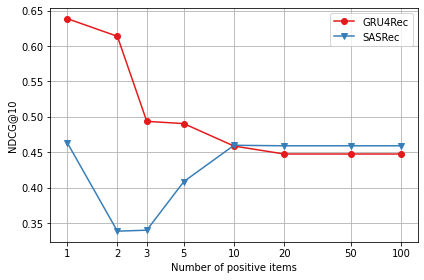

In [35]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

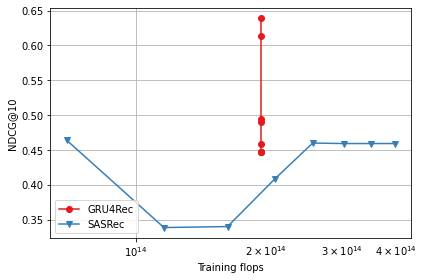

In [36]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [37]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [38]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
6BJtz0l2NU8Ge0rt 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
snrHAgVEX9Y0mQr6 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
6BJtz0l2NU8Ge0rt 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
snrHAgVEX9Y0mQr6 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
6BJtz0l2NU8Ge0rt 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
snrHAgVEX9Y0mQr6 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
6BJtz0l2NU8Ge0rt 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
snrHAgVEX9Y0mQr6 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
6BJtz0l2NU8Ge0rt 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

In [39]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
HpcXkTC9nh68di70 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
xrwcsKySQWdvViNH 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
HpcXkTC9nh68di70 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
xrwcsKySQWdvViNH 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
HpcXkTC9nh68di70 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
xrwcsKySQWdvViNH 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
HpcXkTC9nh68di70 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
xrwcsKySQWdvViNH 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
HpcXkTC9nh68di70 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

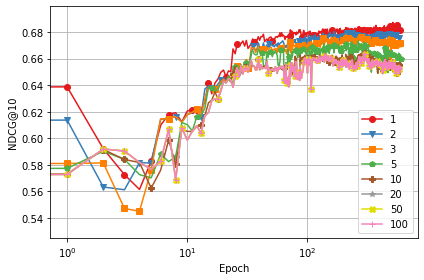

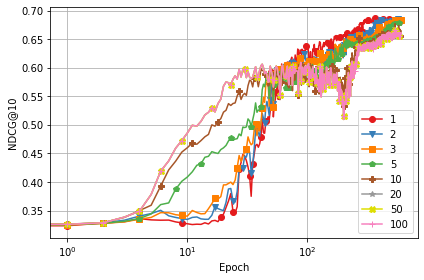

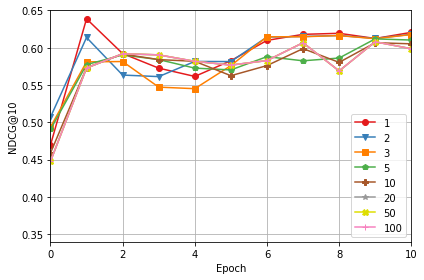

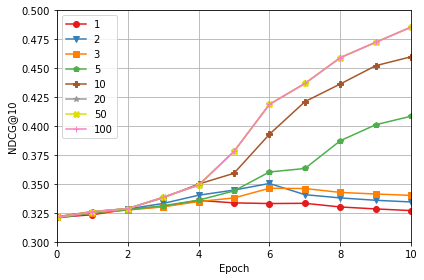

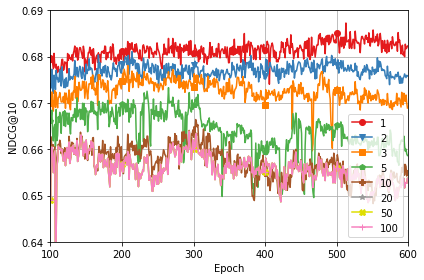

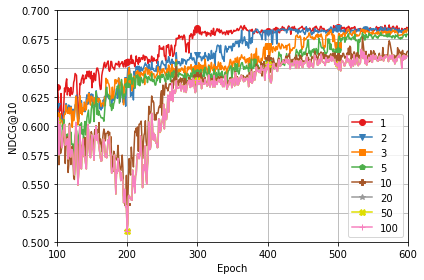

In [40]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.34,"top":0.65}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.30,"top":0.5}
repeated_ax_instructions[3]["legend"] = {"loc": "upper left"}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.64,"top":0.69}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.5,"top":0.7}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### Foursquare TKY

In [41]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [42]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0    foursquare-tky              GRU4Rec   
1    foursquare-tky              GRU4Rec   
2    foursquare-tky              GRU4Rec   
3    foursquare-tky              GRU4Rec   
4    foursquare-tky              GRU4Rec   
5    foursquare-tky              GRU4Rec   
6    foursquare-tky              GRU4Rec   
7    foursquare-tky              GRU4Rec   
8    foursquare-tky               SASRec   
9    foursquare-tky               SASRec   
10   foursquare-tky               SASRec   
11   foursquare-tky               SASRec   
12   foursquare-tky               SASRec   
13   foursquare-tky               SASRec   
14   foursquare-tky               SASRec   
15   foursquare-tky               SASRec   

    data_params.collator_params.simultaneous_lookforward  MAP_@10  MAP_@20  \
0                                                   1      0.2013   0.1295   
1                                                   2      0.1843   0.1207   
2                                                   3      0.1505   0.1017   
3                                                   5      0.1597   0.1074   
4                                                  10      0.1196   0.0831   
5                                                  20      0.1089   0.0755   
6                                                  50      0.1122   0.0782   
7                                                 100      0.1129   0.0788   
8                                                   1      0.2193   0.1394   
9                                                   2      0.1895   0.1231   
10                                                  3      0.1812   0.1184   
11                                                  5      0.1700   0.1122   
12                                                 10      0.1478   0.0994   
13                                                 20      0.1386   0.0936   
14                                                 50      0.1331   0.0902   
15                                                100      0.1428   0.0953   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
0   0.2983    0.7022    0.7158   0.6798         0.0834         0.0444   
1   0.2671    0.6448    0.6626   0.6218         0.0813         0.0441   
2   0.2112    0.5398    0.5622   0.5012         0.0739         0.0413   
3   0.2247    0.5697    0.5914   0.5346         0.0774         0.0430   
4   0.1648    0.4359    0.4663   0.3961         0.0628         0.0374   
5   0.1505    0.3952    0.4272   0.3596         0.0563         0.0345   
6   0.1537    0.4095    0.4400   0.3727         0.0595         0.0358   
7   0.1549    0.4117    0.4428   0.3740         0.0597         0.0360   
8   0.3289    0.7600    0.7718   0.7415         0.0866         0.0456   
9   0.2778    0.6626    0.6788   0.6391         0.0811         0.0438   
10  0.2640    0.6356    0.6544   0.6120         0.0790         0.0432   
11  0.2449    0.6014    0.6197   0.5705         0.0773         0.0423   
12  0.2108    0.5278    0.5555   0.4963         0.0701         0.0405   
13  0.1959    0.4971    0.5218   0.4629         0.0672         0.0384   
14  0.1878    0.4792    0.5038   0.4447         0.0652         0.0375   
15  0.2051    0.5070    0.5329   0.4792         0.0656         0.0379   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
0         0.1530      0.8338      0.8875     0.7649  5.430000e+12   
1         0.1485      0.8129      0.8827     0.7423  5.410000e+12   
2         0.1240      0.7388      0.8264     0.6201  5.470000e+12   
3         0.1332      0.7741      0.8596     0.6659  5.440000e+12   
4         0.1008      0.6280      0.7479     0.5041  5.460000e+12   
5         0.0906      0.5630      0.6899     0.4531  5.480000e+12   
6         0.0961      0.5949      0.7157     0.4806  5.440000e+12   
7         0.0960      0.5970      0.7191     0.4802  5.460000e+12   
8         0.1620      0.8657      0.9128     0.8099  7.140000e+1

In [43]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

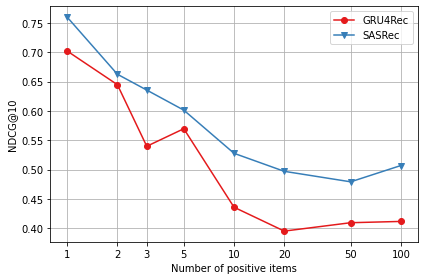

In [44]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

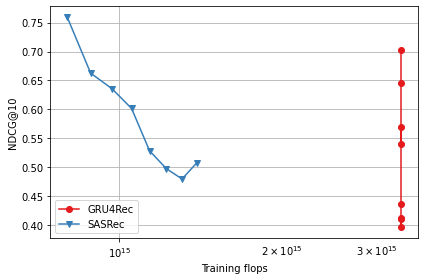

In [45]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [46]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [47]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
5qL3WvtyT2FwRGtB 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
xfk16wi3gDTPByGk 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
5qL3WvtyT2FwRGtB 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
xfk16wi3gDTPByGk 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
5qL3WvtyT2FwRGtB 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
xfk16wi3gDTPByGk 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
5qL3WvtyT2FwRGtB 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
xfk16wi3gDTPByGk 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
5qL3WvtyT2FwRGtB 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

In [48]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
FJnLB2mpv6OVp5Gk 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
xJJ9K44SQ7woxFse 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
FJnLB2mpv6OVp5Gk 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
xJJ9K44SQ7woxFse 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
FJnLB2mpv6OVp5Gk 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
xJJ9K44SQ7woxFse 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
FJnLB2mpv6OVp5Gk 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
xJJ9K44SQ7woxFse 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
FJnLB2mpv6OVp5Gk 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

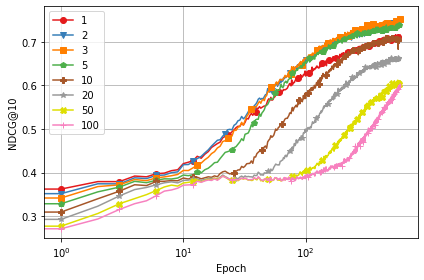

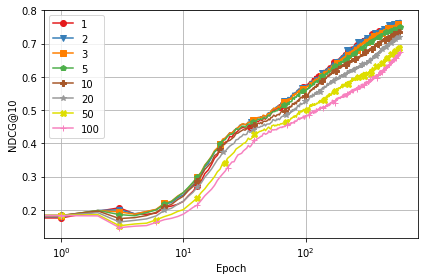

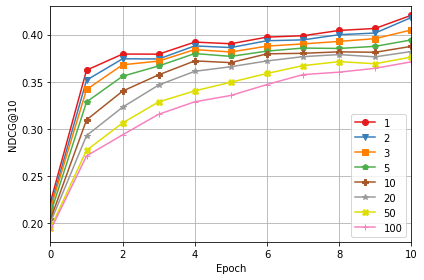

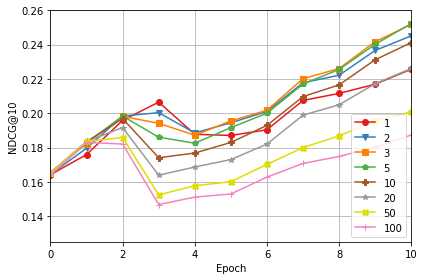

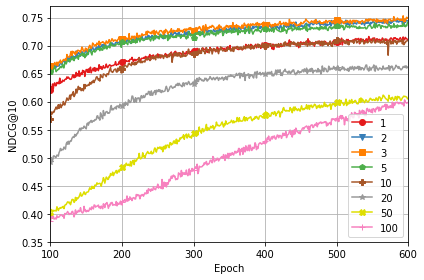

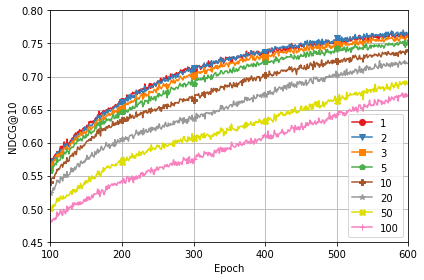

In [49]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.25}
repeated_ax_instructions[0]["legend"] = {"loc": "upper left"}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.18,"top":0.43}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.125,"top":0.26}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.35,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.45,"top":0.80}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [50]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [51]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0             ml-1m              GRU4Rec   
1             ml-1m              GRU4Rec   
2             ml-1m              GRU4Rec   
3             ml-1m              GRU4Rec   
4             ml-1m              GRU4Rec   
5             ml-1m              GRU4Rec   
6             ml-1m              GRU4Rec   
7             ml-1m              GRU4Rec   
8             ml-1m               SASRec   
9             ml-1m               SASRec   
10            ml-1m               SASRec   
11            ml-1m               SASRec   
12            ml-1m               SASRec   
13            ml-1m               SASRec   
14            ml-1m               SASRec   
15            ml-1m               SASRec   

    data_params.collator_params.simultaneous_lookforward  MAP_@10  MAP_@20  \
0                                                   1      0.1566   0.1062   
1                                                   2      0.1419   0.0981   
2                                                   3      0.1371   0.0957   
3                                                   5      0.1341   0.0941   
4                                                  10      0.1176   0.0848   
5                                                  20      0.1100   0.0802   
6                                                  50      0.0911   0.0687   
7                                                 100      0.0653   0.0515   
8                                                   1      0.1643   0.1106   
9                                                   2      0.1571   0.1067   
10                                                  3      0.1490   0.1023   
11                                                  5      0.0939   0.0708   
12                                                 10      0.0612   0.0484   
13                                                 20      0.0599   0.0478   
14                                                 50      0.0584   0.0468   
15                                                100      0.0562   0.0454   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
0   0.2175    0.5594    0.5824   0.5239         0.0784         0.0437   
1   0.1926    0.5134    0.5386   0.4724         0.0756         0.0428   
2   0.1842    0.4989    0.5265   0.4542         0.0749         0.0429   
3   0.1785    0.4893    0.5163   0.4451         0.0748         0.0427   
4   0.1523    0.4367    0.4721   0.3865         0.0699         0.0419   
5   0.1418    0.4118    0.4502   0.3616         0.0667         0.0409   
6   0.1141    0.3499    0.3930   0.2945         0.0596         0.0383   
7   0.0795    0.2577    0.3057   0.2084         0.0461         0.0326   
8   0.2297    0.5848    0.6046   0.5504         0.0806         0.0442   
9   0.2172    0.5608    0.5830   0.5270         0.0791         0.0439   
10  0.2028    0.5353    0.5584   0.4981         0.0779         0.0435   
11  0.1164    0.3607    0.4015   0.3048         0.0623         0.0392   
12  0.0735    0.2410    0.2860   0.1946         0.0435         0.0307   
13  0.0715    0.2366    0.2829   0.1916         0.0433         0.0308   
14  0.0693    0.2318    0.2791   0.1876         0.0426         0.0307   
15  0.0664    0.2245    0.2718   0.1795         0.0417         0.0302   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
0         0.1348      0.7838      0.8747     0.6740  4.940000e+12   
1         0.1258      0.7558      0.8553     0.6291  4.930000e+12   
2         0.1223      0.7488      0.8575     0.6113  4.890000e+12   
3         0.1224      0.7482      0.8543     0.6118  4.910000e+12   
4         0.1089      0.6985      0.8381     0.5444  4.910000e+12   
5         0.1024      0.6672      0.8185     0.5121  4.910000e+12   
6         0.0849      0.5962      0.7664     0.4245  4.840000e+12   
7         0.0615      0.4614      0.6520     0.3076  4.820000e+12   
8         0.1401      0.8063      0.8839     0.7003  1.540000e+1

In [52]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

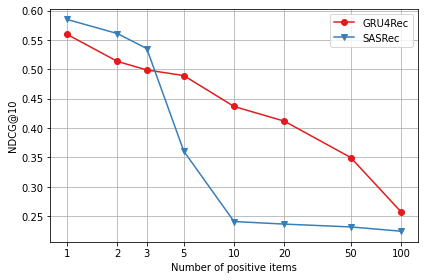

In [53]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

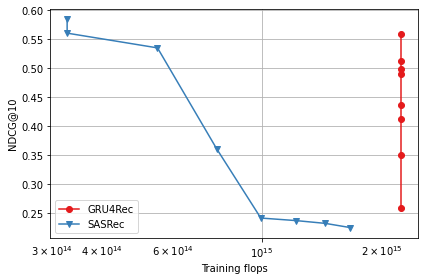

In [54]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [55]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [56]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
7ev5cCHoXB9vYE1z 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
sDM1mgQZrR9euJ02 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
7ev5cCHoXB9vYE1z 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
sDM1mgQZrR9euJ02 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
7ev5cCHoXB9vYE1z 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
sDM1mgQZrR9euJ02 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
7ev5cCHoXB9vYE1z 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
sDM1mgQZrR9euJ02 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
7ev5cCHoXB9vYE1z 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

In [57]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
3YvqrtIwqwN0cbUf 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
wGcyn1FEh5sNJ3lO 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
3YvqrtIwqwN0cbUf 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
wGcyn1FEh5sNJ3lO 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
3YvqrtIwqwN0cbUf 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
wGcyn1FEh5sNJ3lO 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
3YvqrtIwqwN0cbUf 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
wGcyn1FEh5sNJ3lO 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
3YvqrtIwqwN0cbUf 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

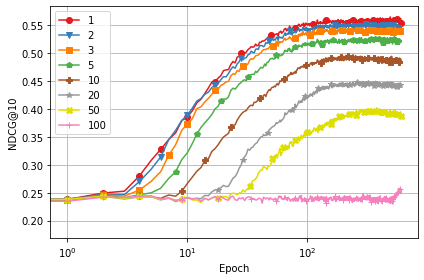

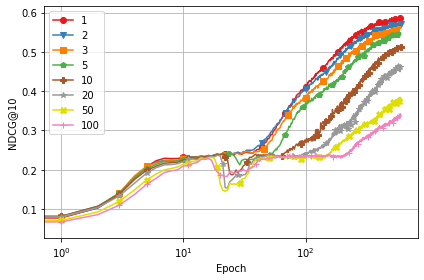

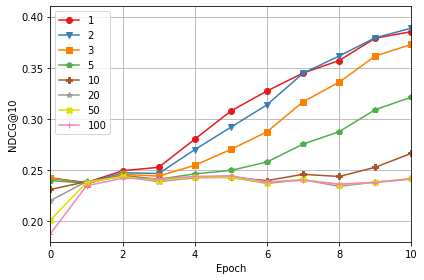

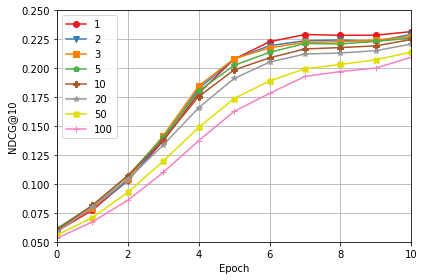

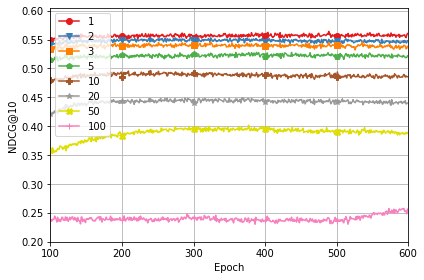

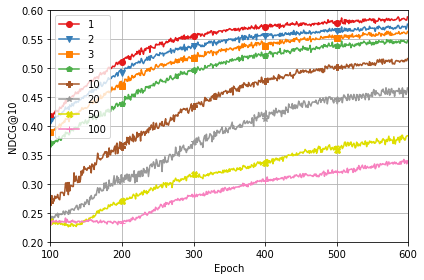

In [58]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.18,"top":0.41}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.2,"top":0.605}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.2,"top":0.60}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

### Num negatives

In [59]:
main_x_column = "data_params.collator_params.num_negatives.train"
main_x_label = "Number of negative items"
super_plot_name = "negatives_NDCG@10"
super_title = "Performance with varying number of negative items"

In [60]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {"data_params.collator_params.simultaneous_lookforward":1}

#### Amazon-beauty

In [61]:
subset_selection["data_params.name"] = "amazon_beauty"
subset_selection.pop("model.rec_model.name",None)

In [62]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0     amazon_beauty              GRU4Rec   
1     amazon_beauty              GRU4Rec   
2     amazon_beauty              GRU4Rec   
3     amazon_beauty              GRU4Rec   
4     amazon_beauty              GRU4Rec   
5     amazon_beauty              GRU4Rec   
6     amazon_beauty              GRU4Rec   
7     amazon_beauty              GRU4Rec   
8     amazon_beauty               SASRec   
9     amazon_beauty               SASRec   
10    amazon_beauty               SASRec   
11    amazon_beauty               SASRec   
12    amazon_beauty               SASRec   
13    amazon_beauty               SASRec   
14    amazon_beauty               SASRec   
15    amazon_beauty               SASRec   

    data_params.collator_params.num_negatives.train  MAP_@10  MAP_@20  MAP_@5  \
0                                                 1   0.1865   0.1165  0.2855   
1                                                 2   0.1653   0.1062  0.2427   
2                                                 3   0.1530   0.1000  0.2184   
3                                                 5   0.1730   0.1104  0.2578   
4                                                10   0.1650   0.1063  0.2416   
5                                                20   0.1693   0.1084  0.2498   
6                                                50   0.2016   0.1246  0.3127   
7                                               100   0.2006   0.1240  0.3113   
8                                                 1   0.1246   0.0858  0.1682   
9                                                 2   0.1744   0.1118  0.2586   
10                                                3   0.1743   0.1110  0.2592   
11                                                5   0.1739   0.1111  0.2580   
12                                               10   0.1755   0.1118  0.2616   
13                                               20   0.1765   0.1122  0.2635   
14                                               50   0.1540   0.1018  0.2176   
15                                              100   0.1987   0.1229  0.3079   

    NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  Precision_@5  \
0     0.6387    0.6457   0.6340         0.0683         0.0356        0.1338   
1     0.5692    0.5763   0.5597         0.0690         0.0359        0.1322   
2     0.5302    0.5409   0.5194         0.0686         0.0365        0.1308   
3     0.5926    0.6030   0.5854         0.0691         0.0366        0.1338   
4     0.5672    0.5765   0.5606         0.0690         0.0363        0.1341   
5     0.5811    0.5888   0.5747         0.0695         0.0363        0.1352   
6     0.6909    0.6940   0.6872         0.0706         0.0359        0.1388   
7     0.6869    0.6915   0.6836         0.0700         0.0359        0.1380   
8     0.4638    0.4744   0.4081         0.0677         0.0359        0.1019   
9     0.6003    0.6094   0.5917         0.0714         0.0375        0.1372   
10    0.5967    0.6045   0.5930         0.0699         0.0365        0.1374   
11    0.5962    0.6054   0.5906         0.0703         0.0369        0.1370   
12    0.6004    0.6103   0.5975         0.0697         0.0368        0.1375   
13    0.6032    0.6128   0.5990         0.0697         0.0368        0.1369   
14    0.5415    0.5521   0.5227         0.0716         0.0379        0.1319   
15    0.6799    0.6831   0.6773         0.0696         0.0354        0.1377   

    Recall_@10  Recall_@20  Recall_@5    test_FLOPS    test_flops  \
0       0.6829      0.7111     0.6688  3.600000e+12  1.080500e+11   
1       0.6900      0.7182     0.6609  3.550000e+12  1.080500e+11   
2       0.6860      0.7300     0.6538  3.660000e+12  1.080500e+11   
3       0.6907      0.7316     0.6688  3.680000e+12  1.080500e+11   
4       0.6900      0.7268     0.6703  3.700000e+12  1.080500e+11   
5       0.6954      0.7268     0.6758  3.540000e+12  1.080500e+11   
6       0.7057      0.7182     0.6939  3.630000e+

In [63]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

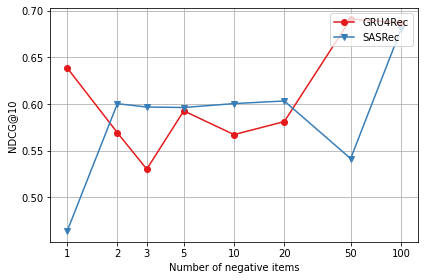

In [64]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

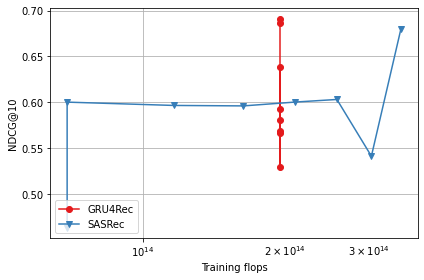

In [65]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [66]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [67]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
E1XjGCYk9NhebtwB 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
rLQi99STMupgaPTC 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
E1XjGCYk9NhebtwB 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
rLQi99STMupgaPTC 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
E1XjGCYk9NhebtwB 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
rLQi99STMupgaPTC 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
E1XjGCYk9NhebtwB 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
rLQi99STMupgaPTC 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
E1XjGCYk9NhebtwB 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

In [68]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
02aTlr7kC6tzuSqW 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
w5EK0LMa3l9y8HDZ 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
02aTlr7kC6tzuSqW 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
w5EK0LMa3l9y8HDZ 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
02aTlr7kC6tzuSqW 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
w5EK0LMa3l9y8HDZ 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
02aTlr7kC6tzuSqW 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
w5EK0LMa3l9y8HDZ 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
02aTlr7kC6tzuSqW 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

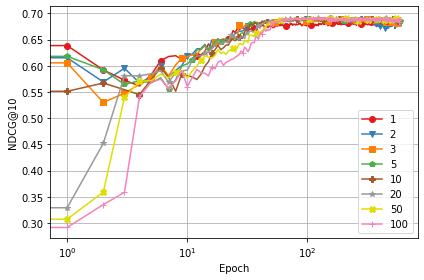

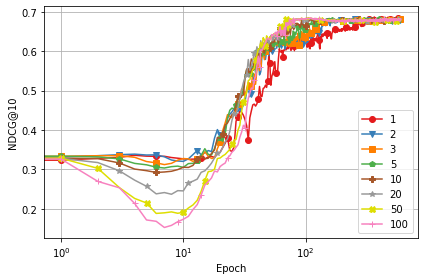

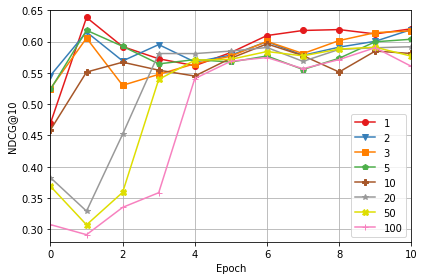

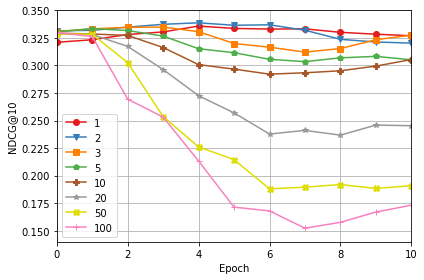

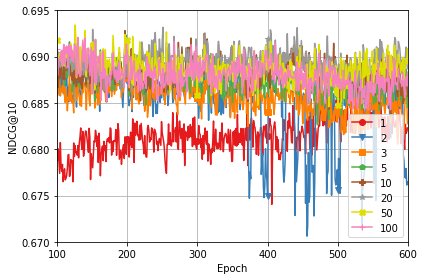

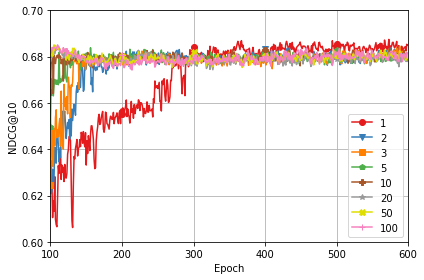

In [69]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
#repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.28,"top":0.65}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.14,"top":0.35}
repeated_ax_instructions[3]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.67,"top":0.695}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.6,"top":0.7}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### Foursquare TKY

In [70]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [71]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0    foursquare-tky              GRU4Rec   
1    foursquare-tky              GRU4Rec   
2    foursquare-tky              GRU4Rec   
3    foursquare-tky              GRU4Rec   
4    foursquare-tky              GRU4Rec   
5    foursquare-tky              GRU4Rec   
6    foursquare-tky              GRU4Rec   
7    foursquare-tky              GRU4Rec   
8    foursquare-tky               SASRec   
9    foursquare-tky               SASRec   
10   foursquare-tky               SASRec   
11   foursquare-tky               SASRec   
12   foursquare-tky               SASRec   
13   foursquare-tky               SASRec   
14   foursquare-tky               SASRec   
15   foursquare-tky               SASRec   

    data_params.collator_params.num_negatives.train  MAP_@10  MAP_@20  MAP_@5  \
0                                                 1   0.2013   0.1295  0.2983   
1                                                 2   0.2072   0.1329  0.3082   
2                                                 3   0.2081   0.1333  0.3104   
3                                                 5   0.2075   0.1328  0.3096   
4                                                10   0.2066   0.1323  0.3079   
5                                                20   0.2078   0.1332  0.3100   
6                                                50   0.2073   0.1329  0.3093   
7                                               100   0.2117   0.1352  0.3169   
8                                                 1   0.2193   0.1394  0.3289   
9                                                 2   0.2225   0.1413  0.3348   
10                                                3   0.2245   0.1423  0.3383   
11                                                5   0.2257   0.1431  0.3404   
12                                               10   0.2298   0.1451  0.3475   
13                                               20   0.2308   0.1458  0.3494   
14                                               50   0.2312   0.1459  0.3503   
15                                              100   0.2325   0.1465  0.3527   

    NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  Precision_@5  \
0     0.7022    0.7158   0.6798         0.0834         0.0444        0.1530   
1     0.7213    0.7343   0.7002         0.0846         0.0449        0.1563   
2     0.7237    0.7370   0.7056         0.0844         0.0448        0.1575   
3     0.7230    0.7353   0.7010         0.0843         0.0446        0.1550   
4     0.7189    0.7312   0.6990         0.0840         0.0444        0.1558   
5     0.7247    0.7386   0.7043         0.0846         0.0450        0.1565   
6     0.7221    0.7381   0.7016         0.0841         0.0452        0.1555   
7     0.7356    0.7495   0.7175         0.0849         0.0452        0.1584   
8     0.7600    0.7718   0.7415         0.0866         0.0456        0.1620   
9     0.7714    0.7816   0.7526         0.0874         0.0457        0.1633   
10    0.7776    0.7870   0.7631         0.0878         0.0458        0.1665   
11    0.7815    0.7921   0.7659         0.0880         0.0461        0.1663   
12    0.7936    0.8035   0.7797         0.0882         0.0461        0.1679   
13    0.7980    0.8083   0.7853         0.0886         0.0463        0.1692   
14    0.7994    0.8088   0.7852         0.0886         0.0461        0.1683   
15    0.8031    0.8120   0.7910         0.0886         0.0461        0.1697   

    Recall_@10  Recall_@20  Recall_@5    test_FLOPS    test_flops  \
0       0.8338      0.8875     0.7649  5.430000e+12  1.850000e+12   
1       0.8461      0.8971     0.7815  5.510000e+12  1.850000e+12   
2       0.8443      0.8966     0.7876  5.470000e+12  1.850000e+12   
3       0.8430      0.8918     0.7750  5.470000e+12  1.850000e+12   
4       0.8404      0.8888     0.7789  5.410000e+12  1.850000e+12   
5       0.8461      0.9006     0.7824  5.450000e+12  1.850000e+12   
6       0.8413      0.9045     0.7776  5.520000e+

In [72]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

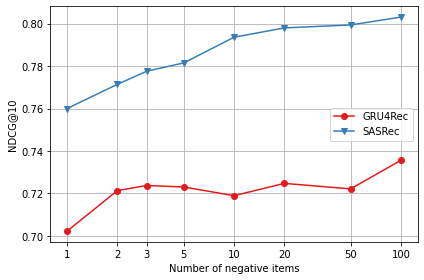

In [73]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "center right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

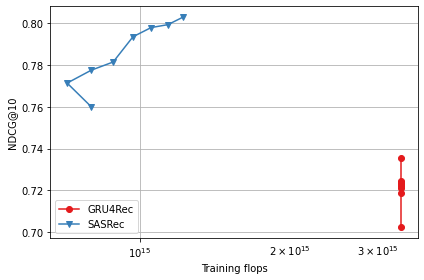

In [74]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [75]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [76]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
645fTGfMU3Gca65a 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
on3EZb82LsG78VlZ 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
645fTGfMU3Gca65a 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
on3EZb82LsG78VlZ 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
645fTGfMU3Gca65a 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
on3EZb82LsG78VlZ 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
645fTGfMU3Gca65a 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
on3EZb82LsG78VlZ 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
645fTGfMU3Gca65a 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

In [77]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
ELZDMpk9iYiOedlP 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
xWaj0hxvcvd1doh9 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
ELZDMpk9iYiOedlP 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
xWaj0hxvcvd1doh9 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
ELZDMpk9iYiOedlP 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
xWaj0hxvcvd1doh9 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
ELZDMpk9iYiOedlP 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
xWaj0hxvcvd1doh9 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
ELZDMpk9iYiOedlP 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

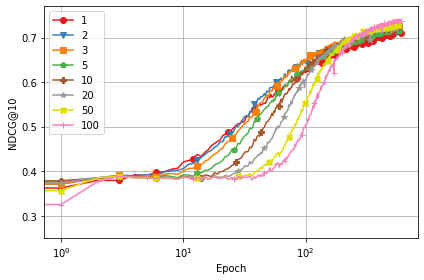

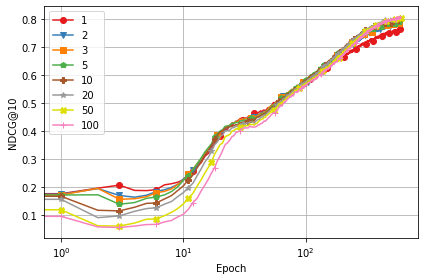

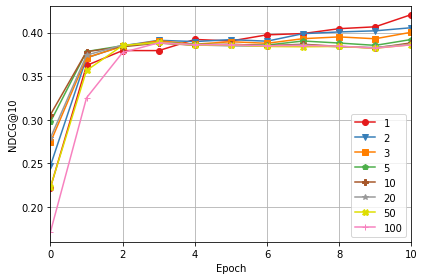

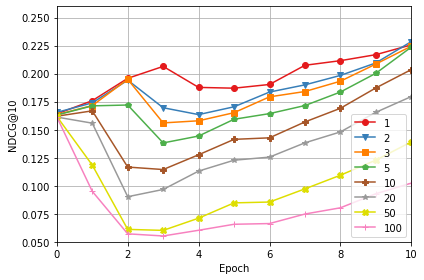

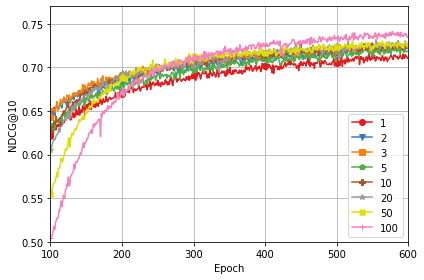

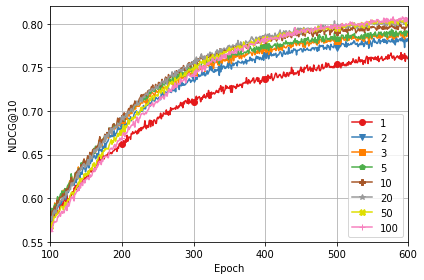

In [78]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.25}
repeated_ax_instructions[0]["legend"] = {"loc": "upper left"}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.16,"top":0.43}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.26}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.5,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.55,"top":0.82}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [79]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [80]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

data_params.name model.rec_model.name  \
0             ml-1m              GRU4Rec   
1             ml-1m              GRU4Rec   
2             ml-1m              GRU4Rec   
3             ml-1m              GRU4Rec   
4             ml-1m              GRU4Rec   
5             ml-1m              GRU4Rec   
6             ml-1m              GRU4Rec   
7             ml-1m              GRU4Rec   
8             ml-1m               SASRec   
9             ml-1m               SASRec   
10            ml-1m               SASRec   
11            ml-1m               SASRec   
12            ml-1m               SASRec   
13            ml-1m               SASRec   
14            ml-1m               SASRec   
15            ml-1m               SASRec   

    data_params.collator_params.num_negatives.train  MAP_@10  MAP_@20  MAP_@5  \
0                                                 1   0.1566   0.1062  0.2175   
1                                                 2   0.1581   0.1069  0.2199   
2                                                 3   0.1587   0.1072  0.2211   
3                                                 5   0.1621   0.1090  0.2271   
4                                                10   0.1632   0.1096  0.2291   
5                                                20   0.1644   0.1103  0.2315   
6                                                50   0.1668   0.1116  0.2355   
7                                               100   0.1675   0.1120  0.2369   
8                                                 1   0.1643   0.1106  0.2297   
9                                                 2   0.1670   0.1121  0.2345   
10                                                3   0.1666   0.1119  0.2338   
11                                                5   0.1693   0.1133  0.2386   
12                                               10   0.1701   0.1135  0.2403   
13                                               20   0.1705   0.1137  0.2413   
14                                               50   0.1708   0.1138  0.2421   
15                                              100   0.1717   0.1143  0.2435   

    NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  Precision_@5  \
0     0.5594    0.5824   0.5239         0.0784         0.0437        0.1348   
1     0.5636    0.5849   0.5294         0.0785         0.0434        0.1359   
2     0.5659    0.5886   0.5296         0.0785         0.0437        0.1347   
3     0.5749    0.5974   0.5440         0.0787         0.0438        0.1384   
4     0.5794    0.6007   0.5474         0.0790         0.0437        0.1384   
5     0.5834    0.6052   0.5513         0.0792         0.0439        0.1387   
6     0.5908    0.6115   0.5600         0.0796         0.0439        0.1402   
7     0.5927    0.6144   0.5614         0.0796         0.0440        0.1399   
8     0.5848    0.6046   0.5504         0.0806         0.0442        0.1401   
9     0.5925    0.6140   0.5615         0.0809         0.0447        0.1425   
10    0.5912    0.6117   0.5593         0.0807         0.0444        0.1419   
11    0.5994    0.6204   0.5692         0.0810         0.0446        0.1434   
12    0.6005    0.6209   0.5720         0.0805         0.0443        0.1436   
13    0.6019    0.6222   0.5745         0.0804         0.0442        0.1440   
14    0.6036    0.6229   0.5746         0.0806         0.0441        0.1432   
15    0.6064    0.6260   0.5777         0.0807         0.0442        0.1438   

    Recall_@10  Recall_@20  Recall_@5    test_FLOPS    test_flops  \
0       0.7838      0.8747     0.6740  4.940000e+12  1.240000e+12   
1       0.7846      0.8685     0.6795  4.900000e+12  1.240000e+12   
2       0.7846      0.8740     0.6735  4.850000e+12  1.240000e+12   
3       0.7874      0.8760     0.6922  4.870000e+12  1.240000e+12   
4       0.7901      0.8743     0.6921  4.870000e+12  1.240000e+12   
5       0.7924      0.8783     0.6934  4.900000e+12  1.240000e+12   
6       0.7957      0.8776     0.7010  4.870000e+

In [81]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

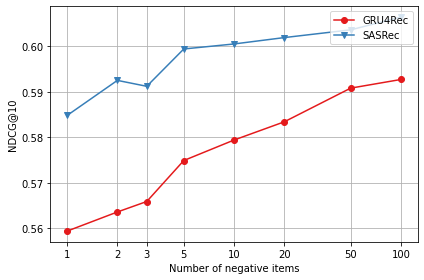

In [82]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

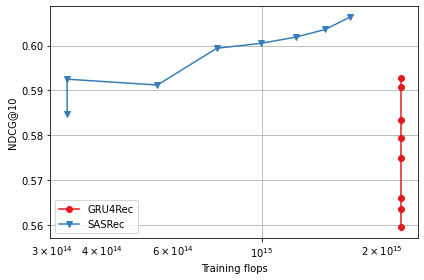

In [83]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [84]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [85]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
34R6BMwhRKx65Rzl 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
sDM1mgQZrR9euJ02 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
34R6BMwhRKx65Rzl 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
sDM1mgQZrR9euJ02 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
34R6BMwhRKx65Rzl 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
sDM1mgQZrR9euJ02 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
34R6BMwhRKx65Rzl 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
sDM1mgQZrR9euJ02 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
34R6BMwhRKx65Rzl 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

In [86]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
EFzdH33nCeesv3WS 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
ugRwyHxlR97amttz 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
EFzdH33nCeesv3WS 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
ugRwyHxlR97amttz 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
EFzdH33nCeesv3WS 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
ugRwyHxlR97amttz 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
EFzdH33nCeesv3WS 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
ugRwyHxlR97amttz 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
EFzdH33nCeesv3WS 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

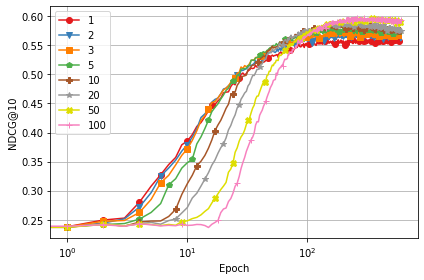

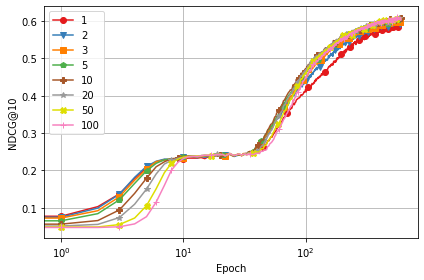

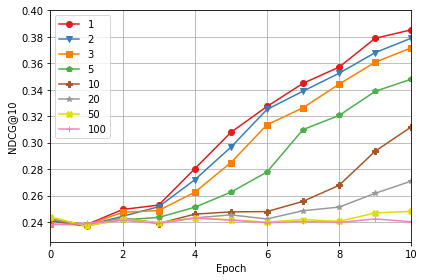

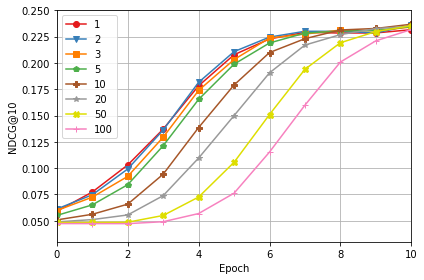

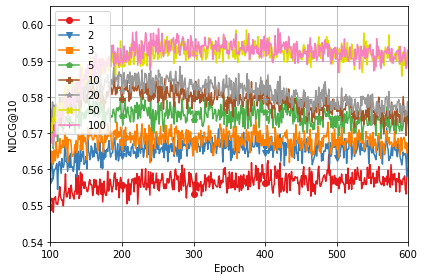

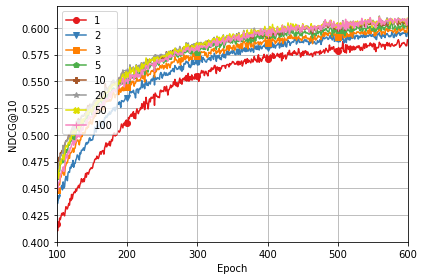

In [87]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.225,"top":0.4}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.03,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.54,"top":0.605}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.4,"top":0.62}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

### Num positives/negatives

In [88]:
main_x_column = "num_pos_neg"
main_x_label = "Number of positive/negative items"
super_plot_name = "pos_neg_NDCG@10"
super_title = "Performance with varying number of positive/negative items"

In [89]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {}
merge_columns = {"num_pos_neg":["data_params.collator_params.simultaneous_lookforward",
                                "data_params.collator_params.num_negatives.train"]}

In [90]:
def subset_to_equal_pos_neg(table):
    def eq_pos_neg(x):
        p,n = x.split("_")
        if p==n: return True
        else: return False
    def comb_pos_neg(x):
        p,n = x.split("_")
        return int(p)
    table = table.loc[table["num_pos_neg"].apply(eq_pos_neg)]
    table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
    # sort by number of positive items
    table = table.sort_values("num_pos_neg")
    return table

#### Amazon-beauty

In [91]:
subset_selection["data_params.name"] = "amazon_beauty"
subset_selection.pop("model.rec_model.name",None)

In [92]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

/tmp/ipykernel_612398/2013779122.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)


data_params.name model.rec_model.name  num_pos_neg  MAP_@10  MAP_@20  \
4     amazon_beauty              GRU4Rec            1   0.1865   0.1165   
26    amazon_beauty               SASRec            1   0.1246   0.0858   
15    amazon_beauty              GRU4Rec            2   0.1140   0.0796   
37    amazon_beauty               SASRec            2   0.1920   0.1196   
17    amazon_beauty              GRU4Rec            3   0.1262   0.0858   
39    amazon_beauty               SASRec            3   0.0950   0.0655   
21    amazon_beauty              GRU4Rec            5   0.1322   0.0885   
43    amazon_beauty               SASRec            5   0.1079   0.0766   
3     amazon_beauty              GRU4Rec           10   0.1261   0.0851   
25    amazon_beauty               SASRec           10   0.1871   0.1166   
13    amazon_beauty              GRU4Rec           20   0.1857   0.1152   
35    amazon_beauty               SASRec           20   0.1933   0.1191   
19    amazon_beauty              GRU4Rec           50   0.1879   0.1155   
41    amazon_beauty               SASRec           50   0.1926   0.1183   
1     amazon_beauty              GRU4Rec          100   0.1870   0.1149   
23    amazon_beauty               SASRec          100   0.1914   0.1176   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
4   0.2855    0.6387    0.6457   0.6340         0.0683         0.0356   
26  0.1682    0.4638    0.4744   0.4081         0.0677         0.0359   
15  0.1531    0.4303    0.4449   0.3704         0.0641         0.0349   
37  0.2948    0.6568    0.6608   0.6534         0.0697         0.0356   
17  0.1717    0.4556    0.4687   0.4290         0.0648         0.0349   
39  0.1413    0.3357    0.4064   0.3193         0.0403         0.0344   
21  0.1824    0.4694    0.4797   0.4501         0.0648         0.0344   
43  0.1509    0.4108    0.4396   0.3473         0.0594         0.0351   
3   0.1728    0.4528    0.4644   0.4245         0.0634         0.0340   
25  0.2874    0.6381    0.6456   0.6371         0.0674         0.0352   
13  0.2854    0.6326    0.6344   0.6326         0.0666         0.0337   
35  0.2999    0.6594    0.6596   0.6594         0.0671         0.0336   
19  0.2928    0.6415    0.6415   0.6415         0.0644         0.0322   
41  0.3001    0.6574    0.6574   0.6574         0.0659         0.0329   
1   0.2915    0.6384    0.6384   0.6384         0.0639         0.0319   
23  0.2984    0.6536    0.6536   0.6536         0.0654         0.0327   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
4         0.1338      0.6829      0.7111     0.6688  3.600000e+12   
26        0.1019      0.6774      0.7190     0.5094  1.420000e+12   
15        0.0917      0.6405      0.6978     0.4584  3.680000e+12   
37        0.1372      0.6970      0.7127     0.6860  1.490000e+12   
17        0.1135      0.6476      0.6986     0.5675  3.670000e+12   
39        0.0702      0.4027      0.6876     0.3509  2.340000e+12   
21        0.1181      0.6476      0.6876     0.5903  3.710000e+12   
43        0.0790      0.5942      0.7025     0.3948  3.240000e+12   
3         0.1100      0.6342      0.6805     0.5502  3.500000e+12   
25        0.1342      0.6743      0.7041     0.6711  3.650000e+12   
13        0.1333      0.6664      0.6743     0.6664  3.710000e+12   
35        0.1342      0.6711      0.6719     0.6711  4.660000e+12   
19        0.1287      0.6436      0.6436     0.6436  3.580000e+12   
41        0.1317      0.6586      0.6586     0.6586  5.590000e+12   
1         0.1278      0.6389      0.6389     0.6389  3.430000e+12   
23        0.1308      0.6538      0.6538     0.6538  6.020000e+12   

      test_flops   train_FLOPS   train_flops  
4   1.080500e+11  3.820000e+12  1.945400e+14  
26  5.145000e+10  1.140000e+12  6.914000e+13  
15  1.080500e+11  3.860000e+12  1.945400e+14  
37  5.145000e+10  1.170000e+12  6.914000e+13  
17  1.080500e+11  3.900000e+12  1.945400e+14  
39  7.754000e+10  1.980000e+1

In [93]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

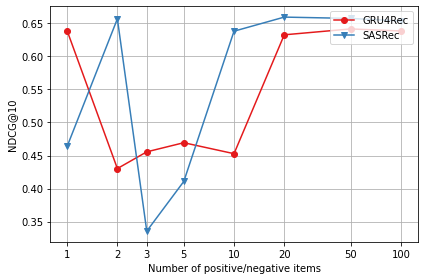

In [94]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

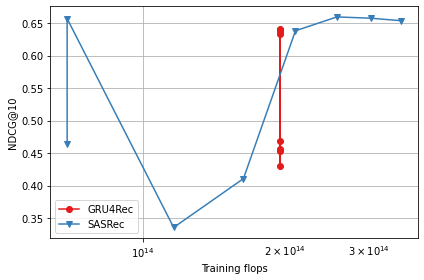

In [95]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [96]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [97]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
rLQi99STMupgaPTC 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
neKdfMfxPYRokYSC 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
rLQi99STMupgaPTC 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
neKdfMfxPYRokYSC 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
rLQi99STMupgaPTC 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
neKdfMfxPYRokYSC 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
rLQi99STMupgaPTC 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
neKdfMfxPYRokYSC 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
rLQi99STMupgaPTC 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

In [98]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch  step  test_F1_@10  test_F1_@20  test_F1_@5  \
w5EK0LMa3l9y8HDZ 0         0     9          NaN          NaN         NaN   
                 2         1    19          NaN          NaN         NaN   
                 4         2    29          NaN          NaN         NaN   
                 6         3    39          NaN          NaN         NaN   
                 8         4    49          NaN          NaN         NaN   
...                      ...   ...          ...          ...         ...   
cOVYeBn4wkIAMbm6 1190    595  5959          NaN          NaN         NaN   
                 1192    596  5969          NaN          NaN         NaN   
                 1194    597  5979          NaN          NaN         NaN   
                 1196    598  5989          NaN          NaN         NaN   
                 1198    599  5999          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
w5EK0LMa3l9y8HDZ 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
cOVYeBn4wkIAMbm6 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
w5EK0LMa3l9y8HDZ 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
cOVYeBn4wkIAMbm6 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
w5EK0LMa3l9y8HDZ 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
cOVYeBn4wkIAMbm6 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
w5EK0LMa3l9y8HDZ 0              NaN         NaN     amazon_beauty   
                 2              NaN         NaN     amazon_beauty   
                 4              NaN         NaN     amazon_beauty   
                 6     

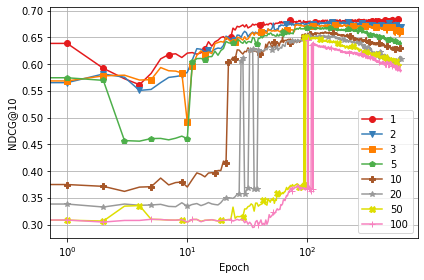

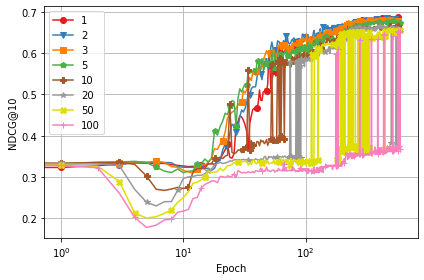

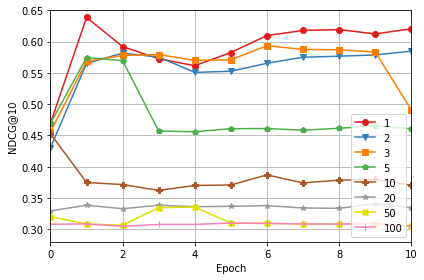

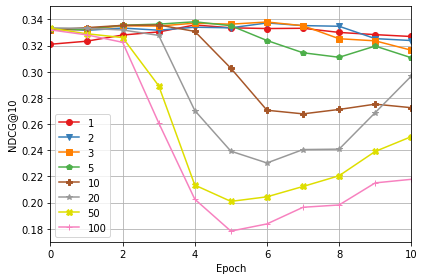

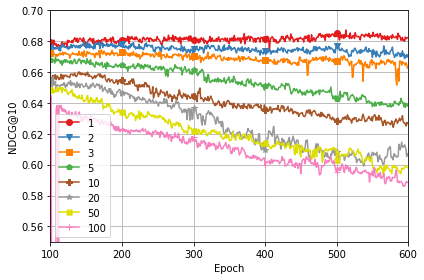

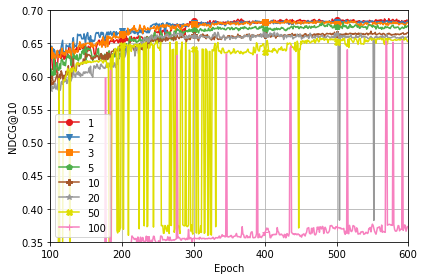

In [99]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
#repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.28,"top":0.65}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.17,"top":0.35}
repeated_ax_instructions[3]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.55,"top":0.7}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[4]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.35,"top":0.7}
repeated_ax_instructions[5].pop("set_xscale",None)
repeated_ax_instructions[5]["legend"] = {"loc": "lower left"}


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### Foursquare TKY

In [100]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [101]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

/tmp/ipykernel_612398/2013779122.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)


data_params.name model.rec_model.name  num_pos_neg  MAP_@10  MAP_@20  \
4    foursquare-tky              GRU4Rec            1   0.2013   0.1295   
26   foursquare-tky               SASRec            1   0.2193   0.1394   
15   foursquare-tky              GRU4Rec            2   0.1872   0.1225   
37   foursquare-tky               SASRec            2   0.2164   0.1376   
17   foursquare-tky              GRU4Rec            3   0.1760   0.1161   
39   foursquare-tky               SASRec            3   0.2160   0.1371   
21   foursquare-tky              GRU4Rec            5   0.1644   0.1096   
43   foursquare-tky               SASRec            5   0.2091   0.1332   
3    foursquare-tky              GRU4Rec           10   0.1797   0.1179   
25   foursquare-tky               SASRec           10   0.2028   0.1290   
13   foursquare-tky              GRU4Rec           20   0.1645   0.1098   
35   foursquare-tky               SASRec           20   0.2037   0.1287   
19   foursquare-tky              GRU4Rec           50   0.1928   0.1236   
41   foursquare-tky               SASRec           50   0.2108   0.1308   
1    foursquare-tky              GRU4Rec          100   0.2002   0.1263   
23   foursquare-tky               SASRec          100   0.2034   0.1258   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
4   0.2983    0.7022    0.7158   0.6798         0.0834         0.0444   
26  0.3289    0.7600    0.7718   0.7415         0.0866         0.0456   
15  0.2717    0.6565    0.6729   0.6304         0.0826         0.0446   
37  0.3248    0.7483    0.7613   0.7348         0.0852         0.0452   
17  0.2526    0.6203    0.6380   0.5940         0.0800         0.0435   
39  0.3247    0.7455    0.7590   0.7326         0.0843         0.0449   
21  0.2325    0.5832    0.6004   0.5522         0.0781         0.0425   
43  0.3126    0.7228    0.7353   0.7102         0.0831         0.0441   
3   0.2589    0.6309    0.6424   0.6042         0.0807         0.0426   
25  0.3019    0.6997    0.7092   0.6894         0.0813         0.0426   
13  0.2319    0.5836    0.5971   0.5517         0.0787         0.0419   
35  0.3045    0.7003    0.7009   0.6929         0.0802         0.0402   
19  0.2827    0.6683    0.6697   0.6530         0.0809         0.0407   
41  0.3235    0.7196    0.7196   0.7185         0.0760         0.0380   
1   0.3002    0.6873    0.6874   0.6804         0.0782         0.0391   
23  0.3138    0.6936    0.6936   0.6932         0.0720         0.0360   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
4         0.1530      0.8338      0.8875     0.7649  5.430000e+12   
26        0.1620      0.8657      0.9128     0.8099  7.140000e+12   
15        0.1492      0.8264      0.8914     0.7462  5.530000e+12   
37        0.1621      0.8522      0.9032     0.8103  7.130000e+12   
17        0.1438      0.8003      0.8700     0.7191  5.500000e+12   
39        0.1608      0.8434      0.8971     0.8042  7.620000e+12   
21        0.1372      0.7811      0.8491     0.6860  5.540000e+12   
43        0.1586      0.8312      0.8814     0.7928  8.200000e+12   
3         0.1451      0.8068      0.8513     0.7253  5.490000e+12   
25        0.1564      0.8129      0.8526     0.7819  9.310000e+12   
13        0.1378      0.7867      0.8386     0.6891  5.510000e+12   
35        0.1560      0.8016      0.8038     0.7798  1.035000e+13   
19        0.1527      0.8094      0.8147     0.7636  5.500000e+12   
41        0.1514      0.7601      0.7601     0.7571  1.024000e+13   
1         0.1522      0.7815      0.7819     0.7610  5.490000e+12   
23        0.1437      0.7200      0.7200     0.7187  1.095000e+13   

      test_flops   train_FLOPS   train_flops  
4   1.850000e+12  5.380000e+12  3.330330e+15  
26  4.682900e+11  7.090000e+12  8.007500e+14  
15  1.850000e+12  5.500000e+12  3.330330e+15  
37  4.213200e+11  6.320000e+12  7.162100e+14  
17  1.850000e+12  5.500000e+12  3.330330e+15  
39  4.682900e+11  7.000000e+1

In [102]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

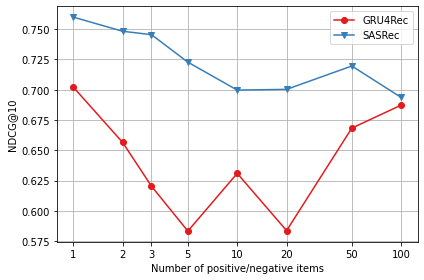

In [103]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

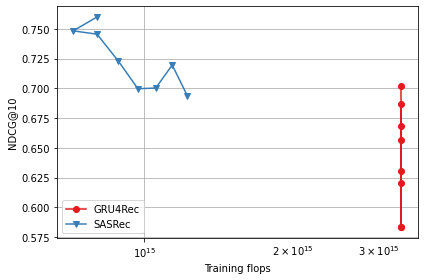

In [104]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [105]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [106]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
E1paMI9iVZOltH16 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
aNaNhFsMzVrkupDg 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
E1paMI9iVZOltH16 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
aNaNhFsMzVrkupDg 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
E1paMI9iVZOltH16 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
aNaNhFsMzVrkupDg 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
E1paMI9iVZOltH16 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
aNaNhFsMzVrkupDg 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
E1paMI9iVZOltH16 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

In [107]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
xJJ9K44SQ7woxFse 0         0     17          NaN          NaN         NaN   
                 2         1     35          NaN          NaN         NaN   
                 4         2     53          NaN          NaN         NaN   
                 6         3     71          NaN          NaN         NaN   
                 8         4     89          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
CxGH5Ykbo1XwXocM 1190    595  10727          NaN          NaN         NaN   
                 1192    596  10745          NaN          NaN         NaN   
                 1194    597  10763          NaN          NaN         NaN   
                 1196    598  10781          NaN          NaN         NaN   
                 1198    599  10799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
xJJ9K44SQ7woxFse 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
CxGH5Ykbo1XwXocM 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
xJJ9K44SQ7woxFse 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
CxGH5Ykbo1XwXocM 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
xJJ9K44SQ7woxFse 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
CxGH5Ykbo1XwXocM 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
xJJ9K44SQ7woxFse 0              NaN         NaN    foursquare-tky   
                 2              NaN         NaN    foursquare-tky   
                 4              NaN         NaN    foursquare-tky   
           

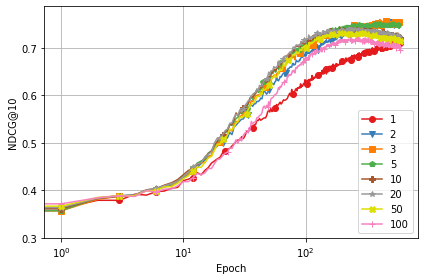

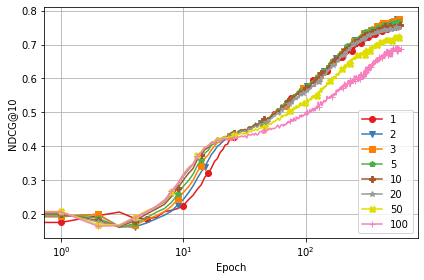

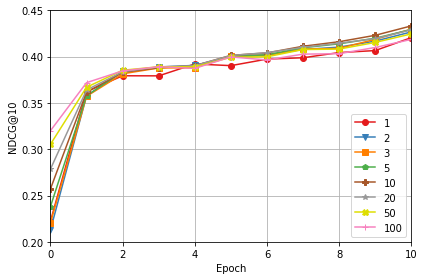

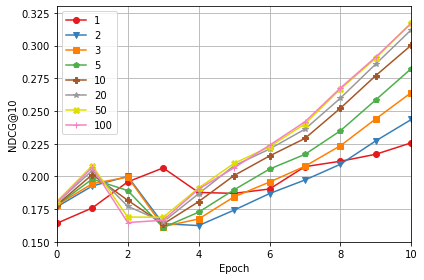

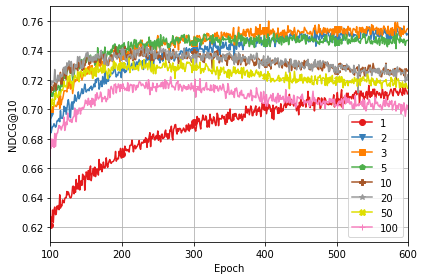

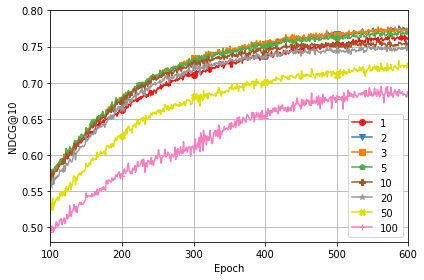

In [108]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.3}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.2,"top":0.45}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.15,"top":0.33}
repeated_ax_instructions[3].pop("set_xscale",None)
repeated_ax_instructions[3]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.61,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.48,"top":0.8}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [109]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

'GRU4Rec'

In [110]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

/tmp/ipykernel_612398/2013779122.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)


data_params.name model.rec_model.name  num_pos_neg  MAP_@10  MAP_@20  \
4             ml-1m              GRU4Rec            1   0.1566   0.1062   
26            ml-1m               SASRec            1   0.1643   0.1106   
15            ml-1m              GRU4Rec            2   0.1508   0.1029   
37            ml-1m               SASRec            2   0.1608   0.1086   
17            ml-1m              GRU4Rec            3   0.1511   0.1029   
39            ml-1m               SASRec            3   0.1590   0.1074   
21            ml-1m              GRU4Rec            5   0.1502   0.1023   
43            ml-1m               SASRec            5   0.1548   0.1048   
3             ml-1m              GRU4Rec           10   0.1364   0.0947   
25            ml-1m               SASRec           10   0.0995   0.0731   
13            ml-1m              GRU4Rec           20   0.1245   0.0879   
35            ml-1m               SASRec           20   0.0764   0.0588   
19            ml-1m              GRU4Rec           50   0.0900   0.0671   
41            ml-1m               SASRec           50   0.0591   0.0470   
1             ml-1m              GRU4Rec          100   0.0616   0.0483   
23            ml-1m               SASRec          100   0.0573   0.0455   

    MAP_@5  NDCG_@10  NDCG_@20  NDCG_@5  Precision_@10  Precision_@20  \
4   0.2175    0.5594    0.5824   0.5239         0.0784         0.0437   
26  0.2297    0.5848    0.6046   0.5504         0.0806         0.0442   
15  0.2074    0.5403    0.5641   0.5041         0.0771         0.0433   
37  0.2238    0.5724    0.5936   0.5400         0.0795         0.0439   
17  0.2087    0.5402    0.5627   0.5060         0.0765         0.0427   
39  0.2210    0.5664    0.5871   0.5329         0.0789         0.0436   
21  0.2061    0.5368    0.5577   0.5020         0.0768         0.0426   
43  0.2151    0.5488    0.5734   0.5200         0.0765         0.0431   
3   0.1834    0.4949    0.5162   0.4539         0.0741         0.0412   
25  0.1249    0.3763    0.4025   0.3247         0.0635         0.0368   
13  0.1642    0.4573    0.4809   0.4122         0.0709         0.0400   
35  0.0935    0.2980    0.3360   0.2459         0.0524         0.0337   
19  0.1125    0.3449    0.3743   0.2927         0.0589         0.0352   
41  0.0705    0.2335    0.2770   0.1889         0.0426         0.0299   
1   0.0745    0.2418    0.2799   0.1971         0.0434         0.0292   
23  0.0678    0.2288    0.2633   0.1820         0.0422         0.0278   

    Precision_@5  Recall_@10  Recall_@20  Recall_@5    test_FLOPS  \
4         0.1348      0.7838      0.8747     0.6740  4.940000e+12   
26        0.1401      0.8063      0.8839     0.7003  1.540000e+12   
15        0.1320      0.7710      0.8651     0.6599  4.890000e+12   
37        0.1391      0.7954      0.8790     0.6957  2.250000e+12   
17        0.1319      0.7649      0.8535     0.6596  4.900000e+12   
39        0.1372      0.7887      0.8710     0.6861  2.980000e+12   
21        0.1324      0.7682      0.8512     0.6618  4.930000e+12   
43        0.1353      0.7649      0.8623     0.6763  3.730000e+12   
3         0.1229      0.7407      0.8237     0.6144  4.900000e+12   
25        0.0951      0.6346      0.7366     0.4755  4.540000e+12   
13        0.1141      0.7093      0.8008     0.5704  4.870000e+12   
35        0.0726      0.5242      0.6730     0.3631  5.490000e+12   
19        0.0855      0.5894      0.7036     0.4273  4.790000e+12   
41        0.0575      0.4262      0.5980     0.2877  6.610000e+12   
1         0.0591      0.4344      0.5841     0.2957  4.870000e+12   
23        0.0553      0.4219      0.5568     0.2767  7.240000e+12   

      test_flops   train_FLOPS   train_flops  
4   1.240000e+12  4.920000e+12  2.224740e+15  
26  2.439200e+11  1.140000e+12  3.277400e+14  
15  1.240000e+12  4.910000e+12  2.224740e+15  
37  3.676200e+11  1.930000e+12  5.504100e+14  
17  1.240000e+12  4.900000e+12  2.224740e+15  
39  4.913200e+11  2.580000e+1

In [111]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

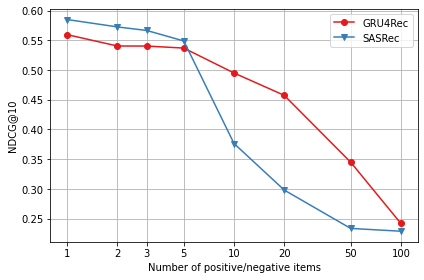

In [112]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

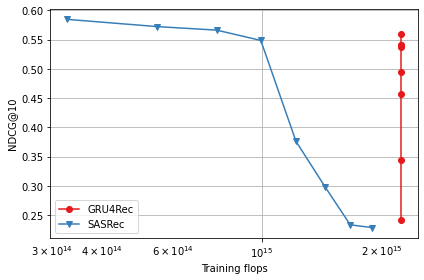

In [113]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [114]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [115]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
sDM1mgQZrR9euJ02 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
FwVv6UoeLnV2s3vp 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
sDM1mgQZrR9euJ02 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
FwVv6UoeLnV2s3vp 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
sDM1mgQZrR9euJ02 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
FwVv6UoeLnV2s3vp 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
sDM1mgQZrR9euJ02 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
FwVv6UoeLnV2s3vp 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
sDM1mgQZrR9euJ02 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

In [116]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

/tmp/ipykernel_612398/688034775.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_612398/176174044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
U3P9JKzDEsgUnihq 0         0     47          NaN          NaN         NaN   
                 2         1     95          NaN          NaN         NaN   
                 4         2    143          NaN          NaN         NaN   
                 6         3    191          NaN          NaN         NaN   
                 8         4    239          NaN          NaN         NaN   
...                      ...    ...          ...          ...         ...   
ggnxNeFGI1T1HkTF 1190    595  28607          NaN          NaN         NaN   
                 1192    596  28655          NaN          NaN         NaN   
                 1194    597  28703          NaN          NaN         NaN   
                 1196    598  28751          NaN          NaN         NaN   
                 1198    599  28799          NaN          NaN         NaN   

                       test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
U3P9JKzDEsgUnihq 0              NaN           NaN          NaN           NaN   
                 2              NaN           NaN          NaN           NaN   
                 4              NaN           NaN          NaN           NaN   
                 6              NaN           NaN          NaN           NaN   
                 8              NaN           NaN          NaN           NaN   
...                             ...           ...          ...           ...   
ggnxNeFGI1T1HkTF 1190           NaN           NaN          NaN           NaN   
                 1192           NaN           NaN          NaN           NaN   
                 1194           NaN           NaN          NaN           NaN   
                 1196           NaN           NaN          NaN           NaN   
                 1198           NaN           NaN          NaN           NaN   

                       test_MRR_@20  ...  test_cpu_energy  test_gpu_energy  \
U3P9JKzDEsgUnihq 0              NaN  ...              NaN              NaN   
                 2              NaN  ...              NaN              NaN   
                 4              NaN  ...              NaN              NaN   
                 6              NaN  ...              NaN              NaN   
                 8              NaN  ...              NaN              NaN   
...                             ...  ...              ...              ...   
ggnxNeFGI1T1HkTF 1190           NaN  ...              NaN              NaN   
                 1192           NaN  ...              NaN              NaN   
                 1194           NaN  ...              NaN              NaN   
                 1196           NaN  ...              NaN              NaN   
                 1198           NaN  ...              NaN              NaN   

                       test_ram_energy  test_energy_consumed  test_flops  \
U3P9JKzDEsgUnihq 0                 NaN                   NaN         NaN   
                 2                 NaN                   NaN         NaN   
                 4                 NaN                   NaN         NaN   
                 6                 NaN                   NaN         NaN   
                 8                 NaN                   NaN         NaN   
...                                ...                   ...         ...   
ggnxNeFGI1T1HkTF 1190              NaN                   NaN         NaN   
                 1192              NaN                   NaN         NaN   
                 1194              NaN                   NaN         NaN   
                 1196              NaN                   NaN         NaN   
                 1198              NaN                   NaN         NaN   

                       test_latency  test_FLOPS  data_params.name  \
U3P9JKzDEsgUnihq 0              NaN         NaN             ml-1m   
                 2              NaN         NaN             ml-1m   
                 4              NaN         NaN             ml-1m   
           

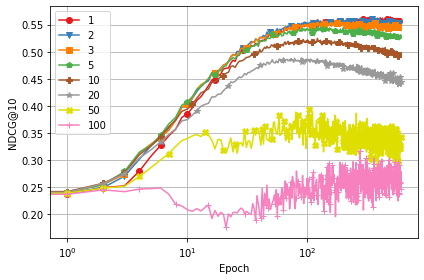

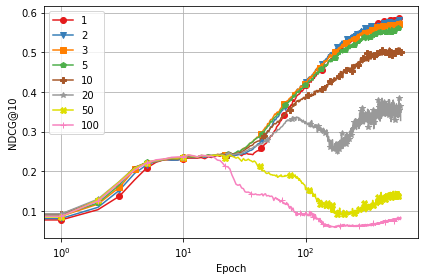

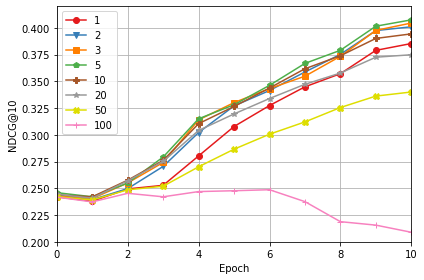

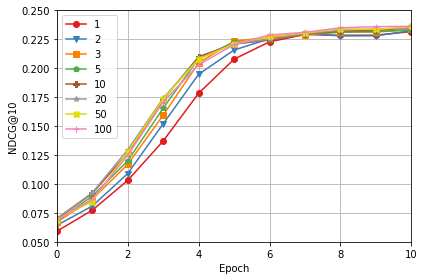

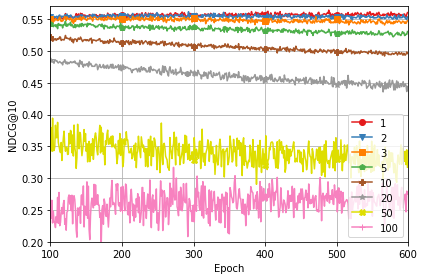

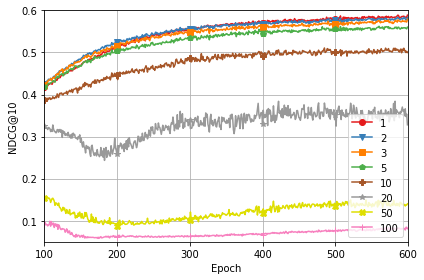

In [117]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.2,"top":0.42}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.2,"top":0.57}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[4]["legend"] = {"loc":"lower right"}
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.05,"top":0.6}
repeated_ax_instructions[5].pop("set_xscale",None)
repeated_ax_instructions[5]["legend"] = {"loc":"lower right"}


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    #rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)